In [256]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras import layers, regularizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.linear_model import Lasso

In [257]:
df = pd.read_csv(r'C:\Users\David Hilbert\JupyterNotebook Projects\biomass_competition\train.csv')
df.head(20)

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750
5,ID1012260530__Dry_Clover_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Clover_g,0.0000
6,ID1012260530__Dry_Dead_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Dead_g,0.0000
7,ID1012260530__Dry_Green_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Green_g,7.6000
8,ID1012260530__Dry_Total_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Total_g,7.6000
9,ID1012260530__GDM_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,GDM_g,7.6000


In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_id      1785 non-null   object 
 1   image_path     1785 non-null   object 
 2   Sampling_Date  1785 non-null   object 
 3   State          1785 non-null   object 
 4   Species        1785 non-null   object 
 5   Pre_GSHH_NDVI  1785 non-null   float64
 6   Height_Ave_cm  1785 non-null   float64
 7   target_name    1785 non-null   object 
 8   target         1785 non-null   float64
dtypes: float64(3), object(6)
memory usage: 125.6+ KB


Пропусков в датасете нет

In [260]:
# Загружаем предобученную модель без финальных слоёв
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

features_list = []

for path in df['image_path']:
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = base_model.predict(x)
    features_list.append(feature)

image_features = np.vstack(features_list)
print(image_features.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━

In [308]:
# 1. Извлечение признаков из изображений (уже сделано)
print(f"Размер image_features: {image_features.shape}")
print(f"Количество объектов в df: {len(df)}")
print(f"Количество уникальных sample_id: {df['sample_id'].nunique()}")

Размер image_features: (1785, 2048)
Количество объектов в df: 1785
Количество уникальных sample_id: 1785


In [310]:
# 2. Преобразование даты в сезонные признаки
def extract_seasonal_features(date_series):
    """
    Извлекает сезонные признаки из даты
    """
    dates = pd.to_datetime(date_series)
    
    # Циклические признаки для месяца (синус и косинус)
    month_sin = np.sin(2 * np.pi * dates.dt.month / 12)
    month_cos = np.cos(2 * np.pi * dates.dt.month / 12)
    
    # Квартал года
    quarter = dates.dt.quarter
    
    # Сезон (можно определить по месяцам)
    def get_season(month):
        if month in [12, 1, 2]:
            return 0  # зима
        elif month in [3, 4, 5]:
            return 1  # весна
        elif month in [6, 7, 8]:
            return 2  # лето
        else:
            return 3  # осень
    
    season = dates.dt.month.apply(get_season)
    
    # День года (циклический)
    day_of_year = dates.dt.dayofyear
    day_sin = np.sin(2 * np.pi * day_of_year / 365)
    day_cos = np.cos(2 * np.pi * day_of_year / 365)
    
    return pd.DataFrame({
        'month': dates.dt.month,
        'month_sin': month_sin,
        'month_cos': month_cos,
        'quarter': quarter,
        'season': season,
        'day_sin': day_sin,
        'day_cos': day_cos
    })

# Применяем функцию к колонке с датой
seasonal_features = extract_seasonal_features(df['Sampling_Date'])
print("Сезонные признаки созданы")

Сезонные признаки созданы


In [314]:
# 3. Обработка категориальных признаков

# Для State и Species используем One-Hot Encoding
categorical_cols = ['State', 'Species']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Подгоняем и преобразуем категориальные признаки
categorical_encoded = encoder.fit_transform(df[categorical_cols])
categorical_feature_names = encoder.get_feature_names_out(categorical_cols)

# Создаем DataFrame с закодированными признаками
categorical_df = pd.DataFrame(
    categorical_encoded, 
    columns=categorical_feature_names,
    index=df.index
)

In [316]:
# 4. Обработка числовых признаков
numerical_cols = ['Pre_GSHH_NDVI', 'Height_Ave_cm']
numerical_df = df[numerical_cols].copy()

# Проверяем на пропуски
print(f"Пропуски в числовых признаках:")
print(numerical_df.isnull().sum())

Пропуски в числовых признаках:
Pre_GSHH_NDVI    0
Height_Ave_cm    0
dtype: int64


In [320]:
# 5. Объединяем все признаки
# Создаем DataFrame для image_features
image_features_df = pd.DataFrame(
    image_features,
    columns=[f'img_feat_{i}' for i in range(image_features.shape[1])],
    index=df.index
)

# Объединяем все признаки
all_features = pd.concat([
    image_features_df,
    seasonal_features,
    categorical_df,
    numerical_df
], axis=1)

print(f"\nОбщее количество признаков: {all_features.shape[1]}")
print(f"Разбивка признаков:")
print(f"  - Признаки изображений: {image_features.shape[1]}")
print(f"  - Сезонные признаки: {seasonal_features.shape[1]}")
print(f"  - Категориальные признаки: {categorical_df.shape[1]}")
print(f"  - Числовые признаки: {numerical_df.shape[1]}")


Общее количество признаков: 2076
Разбивка признаков:
  - Признаки изображений: 2048
  - Сезонные признаки: 7
  - Категориальные признаки: 19
  - Числовые признаки: 2


In [326]:
# 6. Подготовка данных для Multi-Output Regression
def prepare_multi_output_data_with_features(df, all_features):
    """
    Подготавливает данные для multi-output регрессии
    с учетом всех признаков
    """
    # Извлекаем базовый sample_id (убираем информацию о таргете)
    # Например: ID980538882__Dry_Green_g -> ID980538882
    df['base_sample_id'] = df['sample_id'].str.split('__').str[0]
    
    print(f"Уникальных базовых sample_id: {df['base_sample_id'].nunique()}")
    print(f"Примеры базовых sample_id: {df['base_sample_id'].unique()[:10]}")
    
    # Проверяем, сколько записей для каждого базового sample_id
    sample_counts = df['base_sample_id'].value_counts()
    print(f"\nРаспределение количества записей на sample:")
    print(sample_counts.value_counts().sort_index())
    
    # Группируем по базовому sample_id
    grouped = df.groupby('base_sample_id')
    
    X_list = []
    y_list = []
    sample_ids = []
    skipped_samples = []
    
    for base_id, group in grouped:
        if len(group) != 5:
            # Пропускаем, но сохраняем информацию
            skipped_samples.append((base_id, len(group)))
            continue
        
        # Берем признаки из первой строки группы (они одинаковы для всех 5 строк)
        first_idx = group.index[0]
        features = all_features.loc[first_idx].values
        
        X_list.append(features)
        
        # Получаем таргеты (5 разных значений)
        # Сортируем по target_name для сохранения порядка
        sorted_group = group.sort_values('target_name')
        targets = sorted_group['target'].values
        
        # Проверяем, что у нас ровно 5 таргетов
        if len(targets) != 5:
            skipped_samples.append((base_id, len(targets)))
            continue
        
        y_list.append(targets)
        sample_ids.append(base_id)
    
    if skipped_samples:
        print(f"\nПропущено sample_id из-за неправильного количества записей:")
        for sample_id, count in skipped_samples[:20]:  # Покажем первые 20
            print(f"  {sample_id}: {count} записей")
        print(f"Всего пропущено: {len(skipped_samples)} sample_id")
    
    if len(X_list) == 0:
        raise ValueError("Не удалось найти ни одного sample_id с 5 записями!")
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"\nПодготовлено данных:")
    print(f"  - Количество sample_id с 5 записями: {len(sample_ids)}")
    print(f"  - Размер X: {X.shape}")
    print(f"  - Размер y: {y.shape}")
    
    return X, y, sample_ids

# Подготавливаем данные
X, y, sample_ids = prepare_multi_output_data_with_features(df, all_features)

Уникальных базовых sample_id: 357
Примеры базовых sample_id: ['ID1011485656' 'ID1012260530' 'ID1025234388' 'ID1028611175'
 'ID1035947949' 'ID1036339023' 'ID1049634115' 'ID1051144034'
 'ID1052620238' 'ID105271783']

Распределение количества записей на sample:
count
5    357
Name: count, dtype: int64

Подготовлено данных:
  - Количество sample_id с 5 записями: 357
  - Размер X: (357, 2076)
  - Размер y: (357, 5)


In [328]:
# 7. Разделение на train/test

# Разделяем
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nРазделение данных:")
print(f"  - X_train: {X_train.shape}")
print(f"  - X_test: {X_test.shape}")
print(f"  - y_train: {y_train.shape}")
print(f"  - y_test: {y_test.shape}")


Разделение данных:
  - X_train: (285, 2076)
  - X_test: (72, 2076)
  - y_train: (285, 5)
  - y_test: (72, 5)


In [330]:
# 8. Масштабирование признаков
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Масштабирование таргетов
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [332]:
# 9. Создание улучшенной модели Keras

def create_enhanced_multi_output_model(input_dim, n_outputs=5):
    """
    Создает улучшенную модель с регуляризацией и batch normalization
    """
    model = keras.Sequential([
        # Входной слой
        layers.Input(shape=(input_dim,)),
        
        # Первый скрытый слой
        layers.Dense(512, activation='relu', 
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Второй скрытый слой
        layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Третий скрытый слой
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Четвертый скрытый слой
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.1),
        
        # Выходной слой
        layers.Dense(n_outputs, activation='linear')
    ])
    
    # Компиляция с разными оптимизаторами
    optimizer = keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )
    
    model.compile(
        optimizer=optimizer,
        loss='mse',  # Среднеквадратичная ошибка
        metrics=['mae', keras.metrics.RootMeanSquaredError()]
    )
    
    return model

In [334]:
# 10. Обучение модели
# Создаем модель
input_dim = X_train_scaled.shape[1]
model = create_enhanced_multi_output_model(input_dim)

print(f"\nАрхитектура модели:")
model.summary()

# Callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=15,
        min_lr=1e-6,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_multi_output_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Обучение
print("\nНачинаем обучение модели...")
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=1
)


Архитектура модели:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_145 (Dense)               │ (None, 512)            │     1,063,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_142 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,239,813 (4.73 MB)

 Trainable params: 1,238,021 (4.72 MB)

 Non-trainable params: 1,792 (7.00 KB)


Начинаем обучение модели...
Epoch 1/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0902 - mae: 1.3357 - root_mean_squared_error: 1.7109
Epoch 1: val_loss improved from None to 2.23315, saving model to best_multi_output_model.h5



Epoch 1: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 3.9135 - mae: 1.2888 - root_mean_squared_error: 1.6584 - val_loss: 2.2332 - val_mae: 0.7816 - val_root_mean_squared_error: 1.0308 - learning_rate: 0.0010
Epoch 2/200
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1838 - mae: 1.1152 - root_mean_squared_error: 1.4176
Epoch 2: val_loss improved from 2.23315 to 2.11148, saving model to best_multi_output_model.h5



Epoch 2: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.0034 - mae: 1.0609 - root_mean_squared_error: 1.3521 - val_loss: 2.1115 - val_mae: 0.7222 - val_root_mean_squared_error: 0.9642 - learning_rate: 0.0010
Epoch 3/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7655 - mae: 0.9495 - root_mean_squared_error: 1.2571 
Epoch 3: val_loss improved from 2.11148 to 2.02252, saving model to best_multi_output_model.h5



Epoch 3: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.6694 - mae: 0.9370 - root_mean_squared_error: 1.2182 - val_loss: 2.0225 - val_mae: 0.6876 - val_root_mean_squared_error: 0.9122 - learning_rate: 0.0010
Epoch 4/200
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5307 - mae: 0.8928 - root_mean_squared_error: 1.1561
Epoch 4: val_loss improved from 2.02252 to 1.95251, saving model to best_multi_output_model.h5



Epoch 4: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.4907 - mae: 0.8703 - root_mean_squared_error: 1.1391 - val_loss: 1.9525 - val_mae: 0.6790 - val_root_mean_squared_error: 0.8695 - learning_rate: 0.0010
Epoch 5/200
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2992 - mae: 0.8029 - root_mean_squared_error: 1.0491
Epoch 5: val_loss improved from 1.95251 to 1.90354, saving model to best_multi_output_model.h5



Epoch 5: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.3638 - mae: 0.8292 - root_mean_squared_error: 1.0797 - val_loss: 1.9035 - val_mae: 0.6548 - val_root_mean_squared_error: 0.8386 - learning_rate: 0.0010
Epoch 6/200
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3345 - mae: 0.8242 - root_mean_squared_error: 1.0639
Epoch 6: val_loss did not improve from 1.90354
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.2858 - mae: 0.8026 - root_mean_squared_error: 1.0414 - val_loss: 1.9249 - val_mae: 0.6454 - val_root_mean_squared_error: 0.8497 - learning_rate: 0.0010
Epoch 7/200
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2055 - mae: 0.7610 - root_mean_squared_error: 1.0009
Epoch 7: val_loss did not improve from 1.90354
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.2472 - mae: 0.7742 - root_mean_squared_error: 1.0214 - val_loss: 1.9339 - val_mae: 0.6453 - val_root_mean_squared_error: 0.8535 - learning_rate: 0.0010
Epoch 8/200
7/8 ━━


Epoch 9: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.0666 - mae: 0.7061 - root_mean_squared_error: 0.9268 - val_loss: 1.8428 - val_mae: 0.6141 - val_root_mean_squared_error: 0.7967 - learning_rate: 0.0010
Epoch 10/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9882 - mae: 0.6844 - root_mean_squared_error: 0.8828 
Epoch 10: val_loss improved from 1.84279 to 1.80102, saving model to best_multi_output_model.h5



Epoch 10: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.0559 - mae: 0.7041 - root_mean_squared_error: 0.9208 - val_loss: 1.8010 - val_mae: 0.5826 - val_root_mean_squared_error: 0.7700 - learning_rate: 0.0010
Epoch 11/200
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0303 - mae: 0.6971 - root_mean_squared_error: 0.9063
Epoch 11: val_loss improved from 1.80102 to 1.78291, saving model to best_multi_output_model.h5



Epoch 11: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.0009 - mae: 0.6808 - root_mean_squared_error: 0.8903 - val_loss: 1.7829 - val_mae: 0.5667 - val_root_mean_squared_error: 0.7579 - learning_rate: 0.0010
Epoch 12/200
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1925 - mae: 0.7473 - root_mean_squared_error: 0.9909
Epoch 12: val_loss improved from 1.78291 to 1.74865, saving model to best_multi_output_model.h5



Epoch 12: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.1277 - mae: 0.7315 - root_mean_squared_error: 0.9586 - val_loss: 1.7486 - val_mae: 0.5482 - val_root_mean_squared_error: 0.7346 - learning_rate: 0.0010
Epoch 13/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0357 - mae: 0.6805 - root_mean_squared_error: 0.9085 
Epoch 13: val_loss improved from 1.74865 to 1.72887, saving model to best_multi_output_model.h5



Epoch 13: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0046 - mae: 0.6772 - root_mean_squared_error: 0.8918 - val_loss: 1.7289 - val_mae: 0.5437 - val_root_mean_squared_error: 0.7207 - learning_rate: 0.0010
Epoch 14/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9512 - mae: 0.6578 - root_mean_squared_error: 0.8608 
Epoch 14: val_loss did not improve from 1.72887
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0012 - mae: 0.6784 - root_mean_squared_error: 0.8897 - val_loss: 1.7295 - val_mae: 0.5395 - val_root_mean_squared_error: 0.7211 - learning_rate: 0.0010
Epoch 15/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9573 - mae: 0.6618 - root_mean_squared_error: 0.8643 
Epoch 15: val_loss did not improve from 1.72887
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0218 - mae: 0.6686 - root_mean_squared_error: 0.9011 - val_loss: 1.7470 - val_mae: 0.5382 - val_root_mean_squared_error: 0.7327 - learning_rate: 0.0010
Epoch 16/200



Epoch 18: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8835 - mae: 0.6169 - root_mean_squared_error: 0.8194 - val_loss: 1.7266 - val_mae: 0.5290 - val_root_mean_squared_error: 0.7168 - learning_rate: 0.0010
Epoch 19/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8003 - mae: 0.5990 - root_mean_squared_error: 0.7663
Epoch 19: val_loss improved from 1.72663 to 1.71441, saving model to best_multi_output_model.h5



Epoch 19: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8129 - mae: 0.5988 - root_mean_squared_error: 0.7745 - val_loss: 1.7144 - val_mae: 0.5173 - val_root_mean_squared_error: 0.7079 - learning_rate: 0.0010
Epoch 20/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8468 - mae: 0.6011 - root_mean_squared_error: 0.7958 
Epoch 20: val_loss did not improve from 1.71441
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8584 - mae: 0.6072 - root_mean_squared_error: 0.8031 - val_loss: 1.7155 - val_mae: 0.5148 - val_root_mean_squared_error: 0.7086 - learning_rate: 0.0010
Epoch 21/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8098 - mae: 0.5826 - root_mean_squared_error: 0.7720 
Epoch 21: val_loss did not improve from 1.71441
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7951 - mae: 0.5788 - root_mean_squared_error: 0.7627 - val_loss: 1.7174 - val_mae: 0.5240 - val_root_mean_squared_error: 0.7102 - learning_rate: 0.0010
Epoch 22/200



Epoch 22: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8216 - mae: 0.5724 - root_mean_squared_error: 0.7803 - val_loss: 1.6951 - val_mae: 0.5172 - val_root_mean_squared_error: 0.6949 - learning_rate: 0.0010
Epoch 23/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8202 - mae: 0.5859 - root_mean_squared_error: 0.7797 
Epoch 23: val_loss improved from 1.69510 to 1.68686, saving model to best_multi_output_model.h5



Epoch 23: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8000 - mae: 0.5705 - root_mean_squared_error: 0.7667 - val_loss: 1.6869 - val_mae: 0.5083 - val_root_mean_squared_error: 0.6890 - learning_rate: 0.0010
Epoch 24/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7029 - mae: 0.5361 - root_mean_squared_error: 0.7002 
Epoch 24: val_loss did not improve from 1.68686
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7286 - mae: 0.5492 - root_mean_squared_error: 0.7187 - val_loss: 1.6936 - val_mae: 0.5106 - val_root_mean_squared_error: 0.6942 - learning_rate: 0.0010
Epoch 25/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7371 - mae: 0.5569 - root_mean_squared_error: 0.7249 
Epoch 25: val_loss did not improve from 1.68686
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7454 - mae: 0.5594 - root_mean_squared_error: 0.7309 - val_loss: 1.6905 - val_mae: 0.5069 - val_root_mean_squared_error: 0.6932 - learning_rate: 0.0010
Epoch 26/200



Epoch 26: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7480 - mae: 0.5613 - root_mean_squared_error: 0.7339 - val_loss: 1.6811 - val_mae: 0.4944 - val_root_mean_squared_error: 0.6876 - learning_rate: 0.0010
Epoch 27/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6802 - mae: 0.5207 - root_mean_squared_error: 0.6867 
Epoch 27: val_loss improved from 1.68112 to 1.66791, saving model to best_multi_output_model.h5



Epoch 27: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7282 - mae: 0.5469 - root_mean_squared_error: 0.7214 - val_loss: 1.6679 - val_mae: 0.4876 - val_root_mean_squared_error: 0.6791 - learning_rate: 0.0010
Epoch 28/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7193 - mae: 0.5518 - root_mean_squared_error: 0.7161 
Epoch 28: val_loss improved from 1.66791 to 1.66134, saving model to best_multi_output_model.h5



Epoch 28: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7341 - mae: 0.5504 - root_mean_squared_error: 0.7265 - val_loss: 1.6613 - val_mae: 0.4881 - val_root_mean_squared_error: 0.6752 - learning_rate: 0.0010
Epoch 29/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6640 - mae: 0.5204 - root_mean_squared_error: 0.6771 
Epoch 29: val_loss improved from 1.66134 to 1.66032, saving model to best_multi_output_model.h5



Epoch 29: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6824 - mae: 0.5250 - root_mean_squared_error: 0.6908 - val_loss: 1.6603 - val_mae: 0.4924 - val_root_mean_squared_error: 0.6753 - learning_rate: 0.0010
Epoch 30/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6796 - mae: 0.5339 - root_mean_squared_error: 0.6883 
Epoch 30: val_loss did not improve from 1.66032
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7541 - mae: 0.5522 - root_mean_squared_error: 0.7418 - val_loss: 1.6800 - val_mae: 0.5022 - val_root_mean_squared_error: 0.6907 - learning_rate: 0.0010
Epoch 31/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7190 - mae: 0.5481 - root_mean_squared_error: 0.7180 
Epoch 31: val_loss did not improve from 1.66032
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7224 - mae: 0.5547 - root_mean_squared_error: 0.7208 - val_loss: 1.6940 - val_mae: 0.4937 - val_root_mean_squared_error: 0.7009 - learning_rate: 0.0010
Epoch 32/200



Epoch 43: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6606 - mae: 0.5112 - root_mean_squared_error: 0.6791 - val_loss: 1.6559 - val_mae: 0.4785 - val_root_mean_squared_error: 0.6765 - learning_rate: 0.0010
Epoch 44/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6242 - mae: 0.4906 - root_mean_squared_error: 0.6528 
Epoch 44: val_loss did not improve from 1.65586
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5983 - mae: 0.4792 - root_mean_squared_error: 0.6331 - val_loss: 1.6679 - val_mae: 0.4850 - val_root_mean_squared_error: 0.6865 - learning_rate: 0.0010
Epoch 45/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5625 - mae: 0.4611 - root_mean_squared_error: 0.6049 
Epoch 45: val_loss improved from 1.65586 to 1.62603, saving model to best_multi_output_model.h5



Epoch 45: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5753 - mae: 0.4703 - root_mean_squared_error: 0.6158 - val_loss: 1.6260 - val_mae: 0.4629 - val_root_mean_squared_error: 0.6564 - learning_rate: 0.0010
Epoch 46/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5750 - mae: 0.4675 - root_mean_squared_error: 0.6162 
Epoch 46: val_loss improved from 1.62603 to 1.59889, saving model to best_multi_output_model.h5



Epoch 46: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6228 - mae: 0.4897 - root_mean_squared_error: 0.6544 - val_loss: 1.5989 - val_mae: 0.4440 - val_root_mean_squared_error: 0.6366 - learning_rate: 0.0010
Epoch 47/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6464 - mae: 0.5084 - root_mean_squared_error: 0.6726 
Epoch 47: val_loss improved from 1.59889 to 1.59174, saving model to best_multi_output_model.h5



Epoch 47: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6421 - mae: 0.5073 - root_mean_squared_error: 0.6700 - val_loss: 1.5917 - val_mae: 0.4371 - val_root_mean_squared_error: 0.6319 - learning_rate: 0.0010
Epoch 48/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5548 - mae: 0.4514 - root_mean_squared_error: 0.6016 
Epoch 48: val_loss did not improve from 1.59174
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6094 - mae: 0.4759 - root_mean_squared_error: 0.6460 - val_loss: 1.6184 - val_mae: 0.4452 - val_root_mean_squared_error: 0.6536 - learning_rate: 0.0010
Epoch 49/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5508 - mae: 0.4495 - root_mean_squared_error: 0.5998 
Epoch 49: val_loss did not improve from 1.59174
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5619 - mae: 0.4523 - root_mean_squared_error: 0.6093 - val_loss: 1.6060 - val_mae: 0.4331 - val_root_mean_squared_error: 0.6452 - learning_rate: 0.0010
Epoch 50/200



Epoch 52: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5154 - mae: 0.4413 - root_mean_squared_error: 0.5751 - val_loss: 1.5912 - val_mae: 0.4359 - val_root_mean_squared_error: 0.6386 - learning_rate: 0.0010
Epoch 53/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5824 - mae: 0.4547 - root_mean_squared_error: 0.6300 
Epoch 53: val_loss improved from 1.59122 to 1.57114, saving model to best_multi_output_model.h5



Epoch 53: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.5473 - mae: 0.4476 - root_mean_squared_error: 0.6039 - val_loss: 1.5711 - val_mae: 0.4316 - val_root_mean_squared_error: 0.6243 - learning_rate: 0.0010
Epoch 54/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5428 - mae: 0.4449 - root_mean_squared_error: 0.6011 
Epoch 54: val_loss did not improve from 1.57114
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5432 - mae: 0.4533 - root_mean_squared_error: 0.6021 - val_loss: 1.5777 - val_mae: 0.4381 - val_root_mean_squared_error: 0.6308 - learning_rate: 0.0010
Epoch 55/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5493 - mae: 0.4629 - root_mean_squared_error: 0.6080 
Epoch 55: val_loss did not improve from 1.57114
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5385 - mae: 0.4466 - root_mean_squared_error: 0.5996 - val_loss: 1.5970 - val_mae: 0.4436 - val_root_mean_squared_error: 0.6475 - learning_rate: 0.0010
Epoch 56/200



Epoch 66: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4470 - mae: 0.4035 - root_mean_squared_error: 0.5457 - val_loss: 1.5640 - val_mae: 0.4410 - val_root_mean_squared_error: 0.6449 - learning_rate: 0.0010
Epoch 67/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4524 - mae: 0.4200 - root_mean_squared_error: 0.5518 
Epoch 67: val_loss improved from 1.56396 to 1.55352, saving model to best_multi_output_model.h5



Epoch 67: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4613 - mae: 0.4232 - root_mean_squared_error: 0.5602 - val_loss: 1.5535 - val_mae: 0.4392 - val_root_mean_squared_error: 0.6381 - learning_rate: 0.0010
Epoch 68/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4332 - mae: 0.4000 - root_mean_squared_error: 0.5351 
Epoch 68: val_loss did not improve from 1.55352
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4683 - mae: 0.4236 - root_mean_squared_error: 0.5681 - val_loss: 1.5628 - val_mae: 0.4456 - val_root_mean_squared_error: 0.6470 - learning_rate: 0.0010
Epoch 69/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4794 - mae: 0.4137 - root_mean_squared_error: 0.5782 
Epoch 69: val_loss did not improve from 1.55352
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4698 - mae: 0.4134 - root_mean_squared_error: 0.5715 - val_loss: 1.5749 - val_mae: 0.4536 - val_root_mean_squared_error: 0.6581 - learning_rate: 0.0010
Epoch 70/200



Epoch 74: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4249 - mae: 0.4136 - root_mean_squared_error: 0.5410 - val_loss: 1.5371 - val_mae: 0.4367 - val_root_mean_squared_error: 0.6368 - learning_rate: 0.0010
Epoch 75/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3952 - mae: 0.4035 - root_mean_squared_error: 0.5133 
Epoch 75: val_loss improved from 1.53713 to 1.53186, saving model to best_multi_output_model.h5



Epoch 75: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4065 - mae: 0.4063 - root_mean_squared_error: 0.5246 - val_loss: 1.5319 - val_mae: 0.4392 - val_root_mean_squared_error: 0.6334 - learning_rate: 0.0010
Epoch 76/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4170 - mae: 0.4040 - root_mean_squared_error: 0.5352 
Epoch 76: val_loss improved from 1.53186 to 1.52289, saving model to best_multi_output_model.h5



Epoch 76: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4210 - mae: 0.4088 - root_mean_squared_error: 0.5393 - val_loss: 1.5229 - val_mae: 0.4383 - val_root_mean_squared_error: 0.6273 - learning_rate: 0.0010
Epoch 77/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4230 - mae: 0.4076 - root_mean_squared_error: 0.5416 
Epoch 77: val_loss did not improve from 1.52289
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4090 - mae: 0.3970 - root_mean_squared_error: 0.5288 - val_loss: 1.5265 - val_mae: 0.4396 - val_root_mean_squared_error: 0.6299 - learning_rate: 0.0010
Epoch 78/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4510 - mae: 0.4050 - root_mean_squared_error: 0.5658 
Epoch 78: val_loss did not improve from 1.52289
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4175 - mae: 0.3964 - root_mean_squared_error: 0.5359 - val_loss: 1.5503 - val_mae: 0.4472 - val_root_mean_squared_error: 0.6474 - learning_rate: 0.0010
Epoch 79/200



Epoch 96: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3618 - mae: 0.3726 - root_mean_squared_error: 0.5006 - val_loss: 1.5087 - val_mae: 0.4429 - val_root_mean_squared_error: 0.6312 - learning_rate: 5.0000e-04
Epoch 97/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3812 - mae: 0.3893 - root_mean_squared_error: 0.5208 
Epoch 97: val_loss improved from 1.50865 to 1.49159, saving model to best_multi_output_model.h5



Epoch 97: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3772 - mae: 0.3835 - root_mean_squared_error: 0.5173 - val_loss: 1.4916 - val_mae: 0.4372 - val_root_mean_squared_error: 0.6190 - learning_rate: 5.0000e-04
Epoch 98/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3503 - mae: 0.3639 - root_mean_squared_error: 0.4918 
Epoch 98: val_loss improved from 1.49159 to 1.47662, saving model to best_multi_output_model.h5



Epoch 98: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3582 - mae: 0.3709 - root_mean_squared_error: 0.5004 - val_loss: 1.4766 - val_mae: 0.4355 - val_root_mean_squared_error: 0.6082 - learning_rate: 5.0000e-04
Epoch 99/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4080 - mae: 0.3945 - root_mean_squared_error: 0.5483 
Epoch 99: val_loss improved from 1.47662 to 1.47255, saving model to best_multi_output_model.h5



Epoch 99: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3909 - mae: 0.3915 - root_mean_squared_error: 0.5337 - val_loss: 1.4726 - val_mae: 0.4320 - val_root_mean_squared_error: 0.6064 - learning_rate: 5.0000e-04
Epoch 100/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3540 - mae: 0.3773 - root_mean_squared_error: 0.4985 
Epoch 100: val_loss did not improve from 1.47255
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3601 - mae: 0.3805 - root_mean_squared_error: 0.5059 - val_loss: 1.4822 - val_mae: 0.4358 - val_root_mean_squared_error: 0.6158 - learning_rate: 5.0000e-04
Epoch 101/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4269 - mae: 0.4023 - root_mean_squared_error: 0.5663 
Epoch 101: val_loss did not improve from 1.47255
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3822 - mae: 0.3848 - root_mean_squared_error: 0.5289 - val_loss: 1.4934 - val_mae: 0.4394 - val_root_mean_squared_error: 0.6262 - learning_rate: 5.0000e-


Epoch 109: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3166 - mae: 0.3605 - root_mean_squared_error: 0.4785 - val_loss: 1.4669 - val_mae: 0.4281 - val_root_mean_squared_error: 0.6167 - learning_rate: 5.0000e-04
Epoch 110/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3211 - mae: 0.3571 - root_mean_squared_error: 0.4844 
Epoch 110: val_loss improved from 1.46688 to 1.46443, saving model to best_multi_output_model.h5



Epoch 110: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3368 - mae: 0.3730 - root_mean_squared_error: 0.5010 - val_loss: 1.4644 - val_mae: 0.4272 - val_root_mean_squared_error: 0.6162 - learning_rate: 5.0000e-04
Epoch 111/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3051 - mae: 0.3408 - root_mean_squared_error: 0.4697 
Epoch 111: val_loss improved from 1.46443 to 1.45512, saving model to best_multi_output_model.h5



Epoch 111: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3173 - mae: 0.3489 - root_mean_squared_error: 0.4829 - val_loss: 1.4551 - val_mae: 0.4250 - val_root_mean_squared_error: 0.6098 - learning_rate: 5.0000e-04
Epoch 112/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3153 - mae: 0.3695 - root_mean_squared_error: 0.4815 
Epoch 112: val_loss improved from 1.45512 to 1.45161, saving model to best_multi_output_model.h5



Epoch 112: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3407 - mae: 0.3838 - root_mean_squared_error: 0.5078 - val_loss: 1.4516 - val_mae: 0.4253 - val_root_mean_squared_error: 0.6080 - learning_rate: 5.0000e-04
Epoch 113/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3638 - mae: 0.3913 - root_mean_squared_error: 0.5295
Epoch 113: val_loss did not improve from 1.45161
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3470 - mae: 0.3822 - root_mean_squared_error: 0.5154 - val_loss: 1.4520 - val_mae: 0.4261 - val_root_mean_squared_error: 0.6097 - learning_rate: 5.0000e-04
Epoch 114/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3212 - mae: 0.3760 - root_mean_squared_error: 0.4905 
Epoch 114: val_loss improved from 1.45161 to 1.44728, saving model to best_multi_output_model.h5



Epoch 114: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3327 - mae: 0.3767 - root_mean_squared_error: 0.5029 - val_loss: 1.4473 - val_mae: 0.4223 - val_root_mean_squared_error: 0.6070 - learning_rate: 5.0000e-04
Epoch 115/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2983 - mae: 0.3554 - root_mean_squared_error: 0.4687 
Epoch 115: val_loss did not improve from 1.44728
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3160 - mae: 0.3639 - root_mean_squared_error: 0.4876 - val_loss: 1.4478 - val_mae: 0.4211 - val_root_mean_squared_error: 0.6088 - learning_rate: 5.0000e-04
Epoch 116/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3033 - mae: 0.3553 - root_mean_squared_error: 0.4758 
Epoch 116: val_loss did not improve from 1.44728
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3096 - mae: 0.3589 - root_mean_squared_error: 0.4827 - val_loss: 1.4500 - val_mae: 0.4230 - val_root_mean_squared_error: 0.6120 - learning_rate: 5.0000e


Epoch 121: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2711 - mae: 0.3439 - root_mean_squared_error: 0.4520 - val_loss: 1.4457 - val_mae: 0.4219 - val_root_mean_squared_error: 0.6166 - learning_rate: 5.0000e-04
Epoch 122/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2919 - mae: 0.3551 - root_mean_squared_error: 0.4760 
Epoch 122: val_loss improved from 1.44568 to 1.44174, saving model to best_multi_output_model.h5



Epoch 122: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3158 - mae: 0.3593 - root_mean_squared_error: 0.5010 - val_loss: 1.4417 - val_mae: 0.4227 - val_root_mean_squared_error: 0.6150 - learning_rate: 5.0000e-04
Epoch 123/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3092 - mae: 0.3739 - root_mean_squared_error: 0.4952
Epoch 123: val_loss did not improve from 1.44174
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3019 - mae: 0.3697 - root_mean_squared_error: 0.4886 - val_loss: 1.4464 - val_mae: 0.4265 - val_root_mean_squared_error: 0.6195 - learning_rate: 5.0000e-04
Epoch 124/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2916 - mae: 0.3563 - root_mean_squared_error: 0.4779 
Epoch 124: val_loss did not improve from 1.44174
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2946 - mae: 0.3549 - root_mean_squared_error: 0.4819 - val_loss: 1.4448 - val_mae: 0.4257 - val_root_mean_squared_error: 0.6189 - learning_rate: 5.0000e


Epoch 125: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2636 - mae: 0.3344 - root_mean_squared_error: 0.4500 - val_loss: 1.4322 - val_mae: 0.4233 - val_root_mean_squared_error: 0.6099 - learning_rate: 5.0000e-04
Epoch 126/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2800 - mae: 0.3528 - root_mean_squared_error: 0.4690 
Epoch 126: val_loss improved from 1.43215 to 1.43072, saving model to best_multi_output_model.h5



Epoch 126: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2937 - mae: 0.3613 - root_mean_squared_error: 0.4839 - val_loss: 1.4307 - val_mae: 0.4237 - val_root_mean_squared_error: 0.6101 - learning_rate: 5.0000e-04
Epoch 127/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2527 - mae: 0.3311 - root_mean_squared_error: 0.4407 
Epoch 127: val_loss did not improve from 1.43072
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2670 - mae: 0.3396 - root_mean_squared_error: 0.4573 - val_loss: 1.4339 - val_mae: 0.4253 - val_root_mean_squared_error: 0.6140 - learning_rate: 5.0000e-04
Epoch 128/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2693 - mae: 0.3468 - root_mean_squared_error: 0.4612 
Epoch 128: val_loss did not improve from 1.43072
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2729 - mae: 0.3540 - root_mean_squared_error: 0.4655 - val_loss: 1.4321 - val_mae: 0.4272 - val_root_mean_squared_error: 0.6140 - learning_rate: 5.0000e


Epoch 129: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2763 - mae: 0.3456 - root_mean_squared_error: 0.4711 - val_loss: 1.4228 - val_mae: 0.4257 - val_root_mean_squared_error: 0.6080 - learning_rate: 5.0000e-04
Epoch 130/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2768 - mae: 0.3623 - root_mean_squared_error: 0.4730 
Epoch 130: val_loss improved from 1.42283 to 1.42194, saving model to best_multi_output_model.h5



Epoch 130: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2686 - mae: 0.3535 - root_mean_squared_error: 0.4650 - val_loss: 1.4219 - val_mae: 0.4240 - val_root_mean_squared_error: 0.6090 - learning_rate: 5.0000e-04
Epoch 131/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2671 - mae: 0.3385 - root_mean_squared_error: 0.4651 
Epoch 131: val_loss did not improve from 1.42194
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2678 - mae: 0.3358 - root_mean_squared_error: 0.4663 - val_loss: 1.4275 - val_mae: 0.4246 - val_root_mean_squared_error: 0.6153 - learning_rate: 5.0000e-04
Epoch 132/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2466 - mae: 0.3343 - root_mean_squared_error: 0.4440 
Epoch 132: val_loss did not improve from 1.42194
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2335 - mae: 0.3233 - root_mean_squared_error: 0.4303 - val_loss: 1.4260 - val_mae: 0.4268 - val_root_mean_squared_error: 0.6154 - learning_rate: 5.0000e


Epoch 133: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2651 - mae: 0.3437 - root_mean_squared_error: 0.4675 - val_loss: 1.4154 - val_mae: 0.4266 - val_root_mean_squared_error: 0.6082 - learning_rate: 5.0000e-04
Epoch 134/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2532 - mae: 0.3392 - root_mean_squared_error: 0.4561 
Epoch 134: val_loss did not improve from 1.41543
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2580 - mae: 0.3435 - root_mean_squared_error: 0.4617 - val_loss: 1.4156 - val_mae: 0.4259 - val_root_mean_squared_error: 0.6098 - learning_rate: 5.0000e-04
Epoch 135/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2447 - mae: 0.3378 - root_mean_squared_error: 0.4480 
Epoch 135: val_loss did not improve from 1.41543
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2731 - mae: 0.3583 - root_mean_squared_error: 0.4797 - val_loss: 1.4165 - val_mae: 0.4263 - val_root_mean_squared_error: 0.6121 - learning_rate: 5.0000e


Epoch 151: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2751 - mae: 0.3707 - root_mean_squared_error: 0.5043 - val_loss: 1.4136 - val_mae: 0.4337 - val_root_mean_squared_error: 0.6273 - learning_rate: 2.5000e-04
Epoch 152/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1957 - mae: 0.3217 - root_mean_squared_error: 0.4191 
Epoch 152: val_loss improved from 1.41360 to 1.40745, saving model to best_multi_output_model.h5



Epoch 152: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2081 - mae: 0.3284 - root_mean_squared_error: 0.4340 - val_loss: 1.4075 - val_mae: 0.4322 - val_root_mean_squared_error: 0.6232 - learning_rate: 2.5000e-04
Epoch 153/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2345 - mae: 0.3563 - root_mean_squared_error: 0.4642 
Epoch 153: val_loss improved from 1.40745 to 1.40434, saving model to best_multi_output_model.h5



Epoch 153: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2295 - mae: 0.3476 - root_mean_squared_error: 0.4591 - val_loss: 1.4043 - val_mae: 0.4314 - val_root_mean_squared_error: 0.6215 - learning_rate: 2.5000e-04
Epoch 154/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2032 - mae: 0.3156 - root_mean_squared_error: 0.4296 
Epoch 154: val_loss did not improve from 1.40434
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2364 - mae: 0.3429 - root_mean_squared_error: 0.4677 - val_loss: 1.4052 - val_mae: 0.4311 - val_root_mean_squared_error: 0.6230 - learning_rate: 2.5000e-04
Epoch 155/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2704 - mae: 0.3803 - root_mean_squared_error: 0.5022 
Epoch 155: val_loss did not improve from 1.40434
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2334 - mae: 0.3537 - root_mean_squared_error: 0.4655 - val_loss: 1.4078 - val_mae: 0.4306 - val_root_mean_squared_error: 0.6259 - learning_rate: 2.5000e


Epoch 162: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2101 - mae: 0.3335 - root_mean_squared_error: 0.4487 - val_loss: 1.4042 - val_mae: 0.4254 - val_root_mean_squared_error: 0.6294 - learning_rate: 2.5000e-04
Epoch 163/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1791 - mae: 0.3120 - root_mean_squared_error: 0.4137 
Epoch 163: val_loss improved from 1.40422 to 1.40081, saving model to best_multi_output_model.h5



Epoch 163: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1888 - mae: 0.3176 - root_mean_squared_error: 0.4257 - val_loss: 1.4008 - val_mae: 0.4243 - val_root_mean_squared_error: 0.6277 - learning_rate: 2.5000e-04
Epoch 164/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1958 - mae: 0.3379 - root_mean_squared_error: 0.4349 
Epoch 164: val_loss improved from 1.40081 to 1.39842, saving model to best_multi_output_model.h5



Epoch 164: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2005 - mae: 0.3362 - root_mean_squared_error: 0.4406 - val_loss: 1.3984 - val_mae: 0.4246 - val_root_mean_squared_error: 0.6267 - learning_rate: 2.5000e-04
Epoch 165/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1846 - mae: 0.3202 - root_mean_squared_error: 0.4232 
Epoch 165: val_loss improved from 1.39842 to 1.39509, saving model to best_multi_output_model.h5



Epoch 165: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2081 - mae: 0.3286 - root_mean_squared_error: 0.4505 - val_loss: 1.3951 - val_mae: 0.4266 - val_root_mean_squared_error: 0.6250 - learning_rate: 2.5000e-04
Epoch 166/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2073 - mae: 0.3463 - root_mean_squared_error: 0.4504 
Epoch 166: val_loss improved from 1.39509 to 1.38910, saving model to best_multi_output_model.h5



Epoch 166: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1979 - mae: 0.3377 - root_mean_squared_error: 0.4404 - val_loss: 1.3891 - val_mae: 0.4250 - val_root_mean_squared_error: 0.6211 - learning_rate: 2.5000e-04
Epoch 167/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1836 - mae: 0.3262 - root_mean_squared_error: 0.4247 
Epoch 167: val_loss improved from 1.38910 to 1.38545, saving model to best_multi_output_model.h5



Epoch 167: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1983 - mae: 0.3338 - root_mean_squared_error: 0.4420 - val_loss: 1.3855 - val_mae: 0.4243 - val_root_mean_squared_error: 0.6190 - learning_rate: 2.5000e-04
Epoch 168/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2001 - mae: 0.3289 - root_mean_squared_error: 0.4449 
Epoch 168: val_loss improved from 1.38545 to 1.38270, saving model to best_multi_output_model.h5



Epoch 168: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1904 - mae: 0.3257 - root_mean_squared_error: 0.4341 - val_loss: 1.3827 - val_mae: 0.4249 - val_root_mean_squared_error: 0.6176 - learning_rate: 2.5000e-04
Epoch 169/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1931 - mae: 0.3330 - root_mean_squared_error: 0.4382 
Epoch 169: val_loss improved from 1.38270 to 1.37887, saving model to best_multi_output_model.h5



Epoch 169: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1875 - mae: 0.3276 - root_mean_squared_error: 0.4320 - val_loss: 1.3789 - val_mae: 0.4243 - val_root_mean_squared_error: 0.6154 - learning_rate: 2.5000e-04
Epoch 170/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1800 - mae: 0.3173 - root_mean_squared_error: 0.4242 
Epoch 170: val_loss improved from 1.37887 to 1.37699, saving model to best_multi_output_model.h5



Epoch 170: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1825 - mae: 0.3231 - root_mean_squared_error: 0.4275 - val_loss: 1.3770 - val_mae: 0.4241 - val_root_mean_squared_error: 0.6148 - learning_rate: 2.5000e-04
Epoch 171/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1997 - mae: 0.3334 - root_mean_squared_error: 0.4474 
Epoch 171: val_loss improved from 1.37699 to 1.37692, saving model to best_multi_output_model.h5



Epoch 171: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1877 - mae: 0.3229 - root_mean_squared_error: 0.4348 - val_loss: 1.3769 - val_mae: 0.4249 - val_root_mean_squared_error: 0.6155 - learning_rate: 2.5000e-04
Epoch 172/200
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1924 - mae: 0.3075 - root_mean_squared_error: 0.4409
Epoch 172: val_loss improved from 1.37692 to 1.36991, saving model to best_multi_output_model.h5



Epoch 172: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1906 - mae: 0.3150 - root_mean_squared_error: 0.4392 - val_loss: 1.3699 - val_mae: 0.4222 - val_root_mean_squared_error: 0.6106 - learning_rate: 2.5000e-04
Epoch 173/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2283 - mae: 0.3339 - root_mean_squared_error: 0.4801 
Epoch 173: val_loss improved from 1.36991 to 1.36255, saving model to best_multi_output_model.h5



Epoch 173: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2268 - mae: 0.3468 - root_mean_squared_error: 0.4798 - val_loss: 1.3625 - val_mae: 0.4199 - val_root_mean_squared_error: 0.6055 - learning_rate: 2.5000e-04
Epoch 174/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1889 - mae: 0.3067 - root_mean_squared_error: 0.4392 
Epoch 174: val_loss did not improve from 1.36255
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1946 - mae: 0.3197 - root_mean_squared_error: 0.4463 - val_loss: 1.3635 - val_mae: 0.4214 - val_root_mean_squared_error: 0.6072 - learning_rate: 2.5000e-04
Epoch 175/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1893 - mae: 0.3262 - root_mean_squared_error: 0.4412 
Epoch 175: val_loss did not improve from 1.36255
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1890 - mae: 0.3340 - root_mean_squared_error: 0.4412 - val_loss: 1.3681 - val_mae: 0.4235 - val_root_mean_squared_error: 0.6119 - learning_rate: 2.5000e


Epoch 177: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1626 - mae: 0.3074 - root_mean_squared_error: 0.4130 - val_loss: 1.3620 - val_mae: 0.4208 - val_root_mean_squared_error: 0.6089 - learning_rate: 2.5000e-04
Epoch 178/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1666 - mae: 0.3143 - root_mean_squared_error: 0.4189 
Epoch 178: val_loss improved from 1.36203 to 1.35546, saving model to best_multi_output_model.h5



Epoch 178: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1739 - mae: 0.3235 - root_mean_squared_error: 0.4278 - val_loss: 1.3555 - val_mae: 0.4186 - val_root_mean_squared_error: 0.6044 - learning_rate: 2.5000e-04
Epoch 179/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1719 - mae: 0.3162 - root_mean_squared_error: 0.4265 
Epoch 179: val_loss did not improve from 1.35546
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1688 - mae: 0.3132 - root_mean_squared_error: 0.4231 - val_loss: 1.3566 - val_mae: 0.4191 - val_root_mean_squared_error: 0.6063 - learning_rate: 2.5000e-04
Epoch 180/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1719 - mae: 0.3092 - root_mean_squared_error: 0.4276 
Epoch 180: val_loss did not improve from 1.35546
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1722 - mae: 0.3144 - root_mean_squared_error: 0.4286 - val_loss: 1.3604 - val_mae: 0.4202 - val_root_mean_squared_error: 0.6104 - learning_rate: 2.5000e


Epoch 188: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1671 - mae: 0.3255 - root_mean_squared_error: 0.4332 - val_loss: 1.3524 - val_mae: 0.4156 - val_root_mean_squared_error: 0.6112 - learning_rate: 2.5000e-04
Epoch 189/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1720 - mae: 0.3272 - root_mean_squared_error: 0.4393 
Epoch 189: val_loss improved from 1.35237 to 1.34899, saving model to best_multi_output_model.h5



Epoch 189: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1748 - mae: 0.3274 - root_mean_squared_error: 0.4432 - val_loss: 1.3490 - val_mae: 0.4135 - val_root_mean_squared_error: 0.6094 - learning_rate: 2.5000e-04
Epoch 190/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2043 - mae: 0.3430 - root_mean_squared_error: 0.4759 
Epoch 190: val_loss improved from 1.34899 to 1.34676, saving model to best_multi_output_model.h5



Epoch 190: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1841 - mae: 0.3293 - root_mean_squared_error: 0.4549 - val_loss: 1.3468 - val_mae: 0.4131 - val_root_mean_squared_error: 0.6085 - learning_rate: 2.5000e-04
Epoch 191/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1538 - mae: 0.3154 - root_mean_squared_error: 0.4211 
Epoch 191: val_loss improved from 1.34676 to 1.34533, saving model to best_multi_output_model.h5



Epoch 191: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1616 - mae: 0.3194 - root_mean_squared_error: 0.4308 - val_loss: 1.3453 - val_mae: 0.4132 - val_root_mean_squared_error: 0.6084 - learning_rate: 2.5000e-04
Epoch 192/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1612 - mae: 0.3049 - root_mean_squared_error: 0.4314 
Epoch 192: val_loss improved from 1.34533 to 1.34241, saving model to best_multi_output_model.h5



Epoch 192: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1581 - mae: 0.3096 - root_mean_squared_error: 0.4282 - val_loss: 1.3424 - val_mae: 0.4131 - val_root_mean_squared_error: 0.6070 - learning_rate: 2.5000e-04
Epoch 193/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1586 - mae: 0.3241 - root_mean_squared_error: 0.4300 
Epoch 193: val_loss improved from 1.34241 to 1.33613, saving model to best_multi_output_model.h5



Epoch 193: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1587 - mae: 0.3272 - root_mean_squared_error: 0.4303 - val_loss: 1.3361 - val_mae: 0.4121 - val_root_mean_squared_error: 0.6029 - learning_rate: 2.5000e-04
Epoch 194/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1418 - mae: 0.3088 - root_mean_squared_error: 0.4109 
Epoch 194: val_loss improved from 1.33613 to 1.33220, saving model to best_multi_output_model.h5



Epoch 194: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1614 - mae: 0.3169 - root_mean_squared_error: 0.4350 - val_loss: 1.3322 - val_mae: 0.4101 - val_root_mean_squared_error: 0.6007 - learning_rate: 2.5000e-04
Epoch 195/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1441 - mae: 0.2994 - root_mean_squared_error: 0.4150 
Epoch 195: val_loss improved from 1.33220 to 1.32944, saving model to best_multi_output_model.h5



Epoch 195: finished saving model to best_multi_output_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1446 - mae: 0.3008 - root_mean_squared_error: 0.4168 - val_loss: 1.3294 - val_mae: 0.4090 - val_root_mean_squared_error: 0.5994 - learning_rate: 2.5000e-04
Epoch 196/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1510 - mae: 0.3171 - root_mean_squared_error: 0.4255 
Epoch 196: val_loss did not improve from 1.32944
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1415 - mae: 0.3053 - root_mean_squared_error: 0.4145 - val_loss: 1.3298 - val_mae: 0.4095 - val_root_mean_squared_error: 0.6008 - learning_rate: 2.5000e-04
Epoch 197/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1259 - mae: 0.2945 - root_mean_squared_error: 0.3954
Epoch 197: val_loss did not improve from 1.32944
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1587 - mae: 0.3179 - root_mean_squared_error: 0.4363 - val_loss: 1.3299 - val_mae: 0.4100 - val_root_mean_squared_error: 0.6018 - learning_rate: 2.5000e

In [336]:
# 11. Оценка модели

# Предсказание
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Вычисляем метрики для каждого таргета
print("\nМетрики для каждого таргета:")
target_names = df['target_name'].unique()[:5]

for i in range(5):
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    
    print(f"Таргет {i+1} ({target_names[i] if i < len(target_names) else 'Unknown'}):")
    print(f"  R² = {r2:.4f}")
    print(f"  MSE = {mse:.4f}")
    print(f"  MAE = {mae:.4f}")

# Средние метрики
print("\nСредние метрики по всем таргетам:")
avg_r2 = np.mean([r2_score(y_test[:, i], y_pred[:, i]) for i in range(5)])
avg_mse = np.mean([mean_squared_error(y_test[:, i], y_pred[:, i]) for i in range(5)])
avg_mae = np.mean([mean_absolute_error(y_test[:, i], y_pred[:, i]) for i in range(5)])

print(f"Средний R²: {avg_r2:.4f}")
print(f"Средний MSE: {avg_mse:.4f}")
print(f"Средний MAE: {avg_mae:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Метрики для каждого таргета:
Таргет 1 (Dry_Clover_g):
  R² = 0.6354
  MSE = 64.9703
  MAE = 5.2084
Таргет 2 (Dry_Dead_g):
  R² = 0.3020
  MSE = 100.9575
  MAE = 6.7287
Таргет 3 (Dry_Green_g):
  R² = 0.6229
  MSE = 177.3615
  MAE = 8.8762
Таргет 4 (Dry_Total_g):
  R² = 0.3799
  MSE = 361.0739
  MAE = 13.5268
Таргет 5 (GDM_g):
  R² = 0.5886
  MSE = 197.8272
  MAE = 10.2378

Средние метрики по всем таргетам:
Средний R²: 0.5058
Средний MSE: 180.4381
Средний MAE: 8.9155


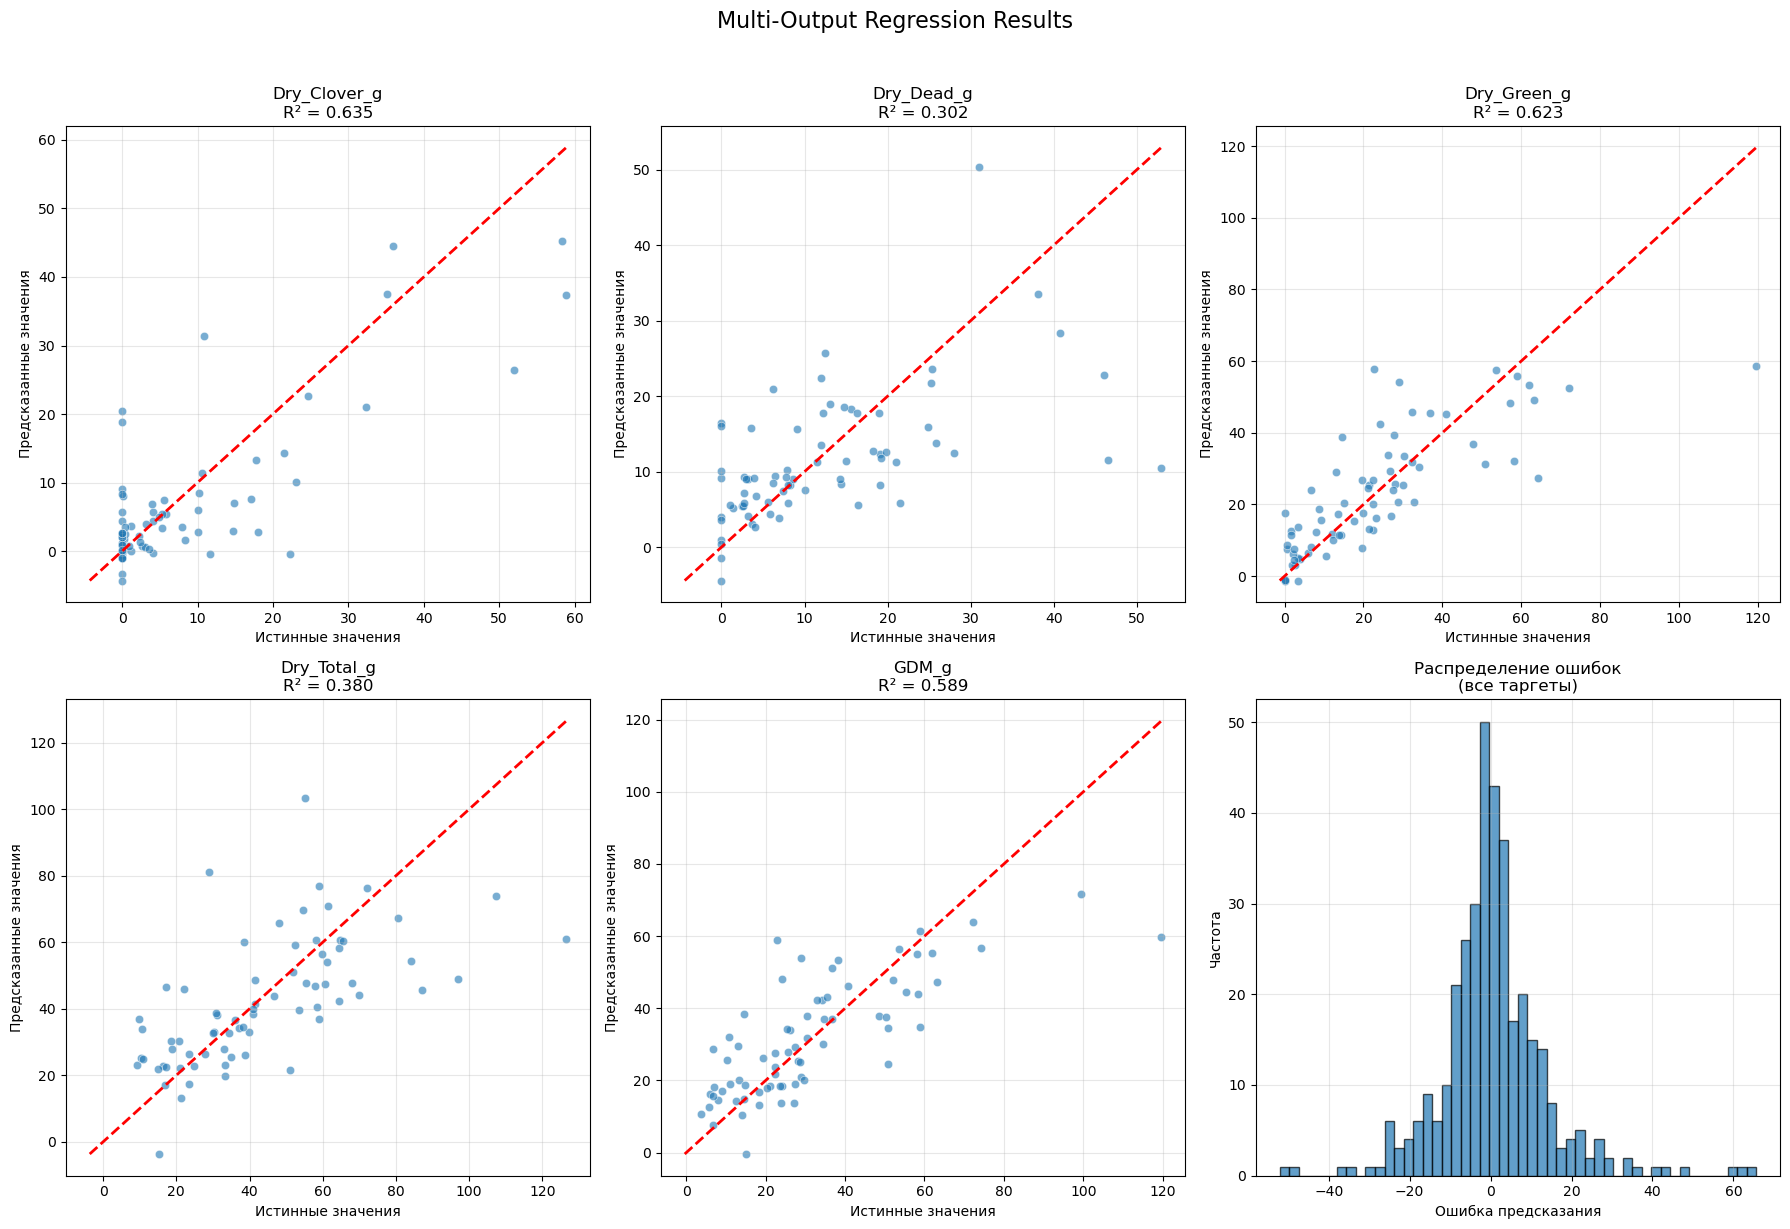

In [338]:
# 12. Визуализация результатов

def plot_results(y_true, y_pred, target_names):
    """Визуализация предсказаний"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Графики для каждого таргета
    for i in range(5):
        ax = axes[i]
        ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, edgecolors='w', linewidth=0.5)
        
        # Линия идеального предсказания
        min_val = min(y_true[:, i].min(), y_pred[:, i].min())
        max_val = max(y_true[:, i].max(), y_pred[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        
        ax.set_xlabel('Истинные значения')
        ax.set_ylabel('Предсказанные значения')
        ax.set_title(f'{target_names[i] if i < len(target_names) else f"Target {i+1}"}\nR² = {r2_score(y_true[:, i], y_pred[:, i]):.3f}')
        ax.grid(True, alpha=0.3)
    
    # Гистограмма ошибок для всех таргетов
    ax = axes[5]
    errors = y_true - y_pred
    ax.hist(errors.flatten(), bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Ошибка предсказания')
    ax.set_ylabel('Частота')
    ax.set_title('Распределение ошибок\n(все таргеты)')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Multi-Output Regression Results', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Визуализация
plot_results(y_test, y_pred, target_names)

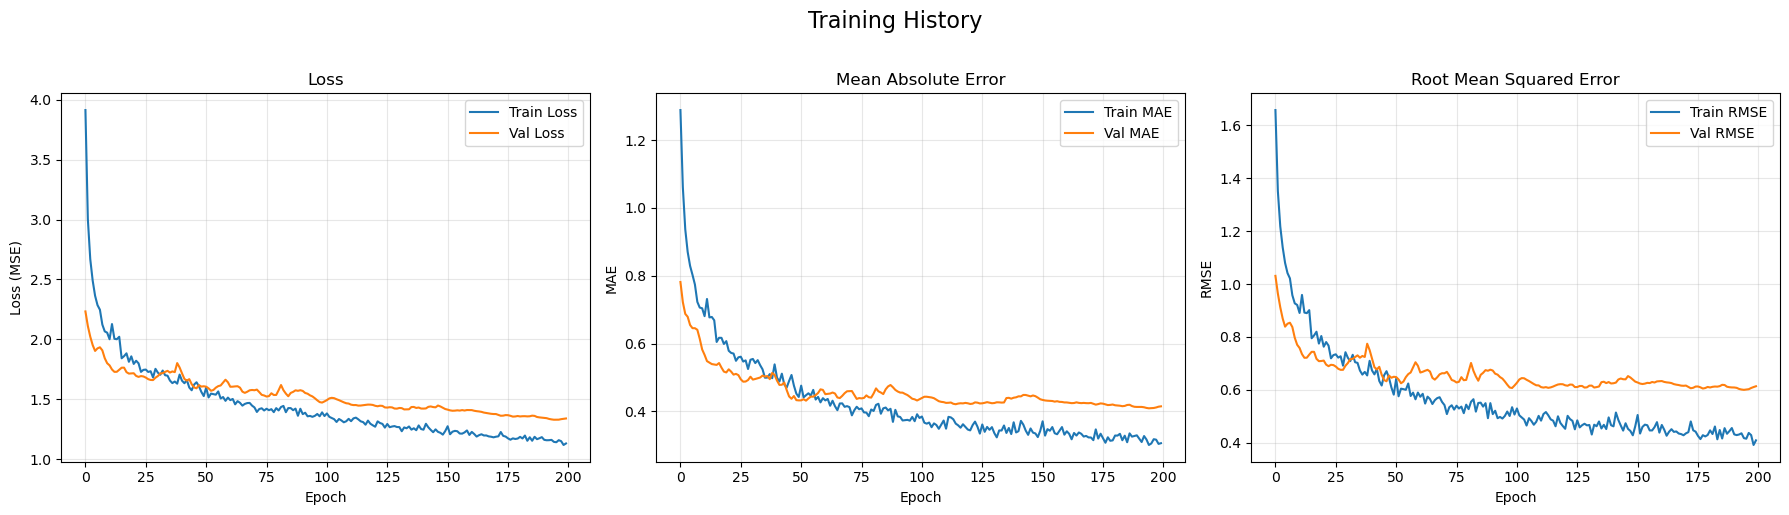

In [340]:
# 13. Визуализация истории обучения
def plot_training_history(history):
    """Визуализация процесса обучения"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # MAE
    axes[1].plot(history.history['mae'], label='Train MAE')
    axes[1].plot(history.history['val_mae'], label='Val MAE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('Mean Absolute Error')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # RMSE
    if 'root_mean_squared_error' in history.history:
        axes[2].plot(history.history['root_mean_squared_error'], label='Train RMSE')
        axes[2].plot(history.history['val_root_mean_squared_error'], label='Val RMSE')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('RMSE')
        axes[2].set_title('Root Mean Squared Error')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
    
    plt.suptitle('Training History', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_training_history(history)

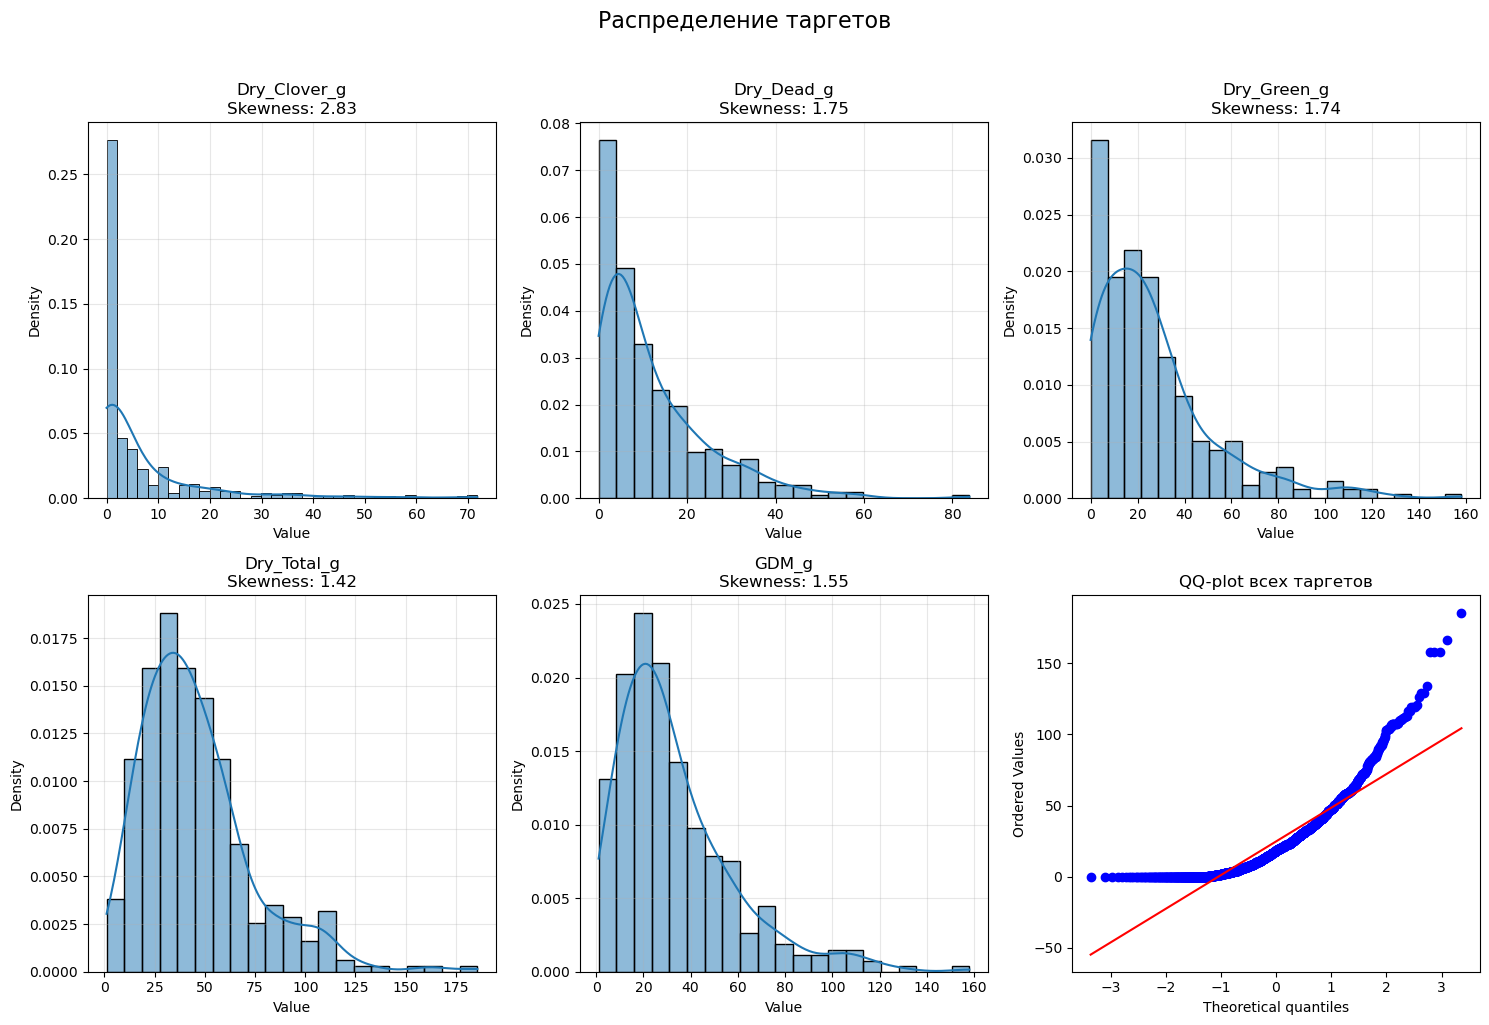


Выбросы (по правилу 3 сигм):
Dry_Clover_g: 11 выбросов (3.1%)
Dry_Dead_g: 6 выбросов (1.7%)
Dry_Green_g: 10 выбросов (2.8%)
Dry_Total_g: 4 выбросов (1.1%)
GDM_g: 6 выбросов (1.7%)


In [359]:
def analyze_target_distributions(y, target_names):
    """Анализ распределения таргетов"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (ax, name) in enumerate(zip(axes[:5], target_names)):
        # Гистограмма с KDE
        sns.histplot(y[:, i], ax=ax, kde=True, stat="density")
        ax.set_title(f'{name}\nSkewness: {stats.skew(y[:, i]):.2f}')
        ax.set_xlabel('Value')
        ax.grid(True, alpha=0.3)
    
    # QQ-plot для нормальности
    ax = axes[5]
    stats.probplot(y.flatten(), dist="norm", plot=ax)
    ax.set_title('QQ-plot всех таргетов')
    
    plt.suptitle('Распределение таргетов', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Проверка на выбросы
    print("\nВыбросы (по правилу 3 сигм):")
    for i, name in enumerate(target_names):
        mean_val = np.mean(y[:, i])
        std_val = np.std(y[:, i])
        outliers = np.sum(np.abs(y[:, i] - mean_val) > 3 * std_val)
        print(f"{name}: {outliers} выбросов ({outliers/len(y)*100:.1f}%)")

# Анализируем
analyze_target_distributions(y, target_names)

Рассмотрим распределение таргетов. Как видно из графиков: распределение скошено в лево.
В данном случае может помочь преобразование boxcox

=== ПРЕОБРАЗОВАНИЕ ТАРГЕТОВ ===
Применяем преобразование квадратным корнем

Статистики до и после преобразования:

Dry_Clover_g:
  До: mean=6.65, std=12.10, min=0.00, max=71.79
  После: mean=1.69, std=1.95, min=0.00, max=8.47

Dry_Dead_g:
  До: mean=12.04, std=12.38, min=0.00, max=83.84
  После: mean=2.97, std=1.79, min=0.00, max=9.16

Dry_Green_g:
  До: mean=26.62, std=25.37, min=0.00, max=157.98
  После: mean=4.54, std=2.46, min=0.00, max=12.57

=== РАЗДЕЛЕНИЕ ДАННЫХ ===
X_train: (285, 2076)
X_test: (72, 2076)
y_train (transformed): (285, 5)
y_test (transformed): (72, 5)

=== МАСШТАБИРОВАНИЕ ПРИЗНАКОВ ===
Масштабирование признаков завершено

=== СОЗДАНИЕ АНСАМБЛЯ МОДЕЛЕЙ ===

Обучение RandomForest...
  Средний R²: 0.6539
  R² по таргетам: ['0.657', '0.568', '0.768', '0.590', '0.686']

Обучение GradientBoosting...
  Средний R²: 0.6287
  R² по таргетам: ['0.672', '0.538', '0.743', '0.492', '0.698']

Обучение XGBoost...
  Средний R²: 0.6679
  R² по таргетам: ['0.680', '0.559', '0.758', 

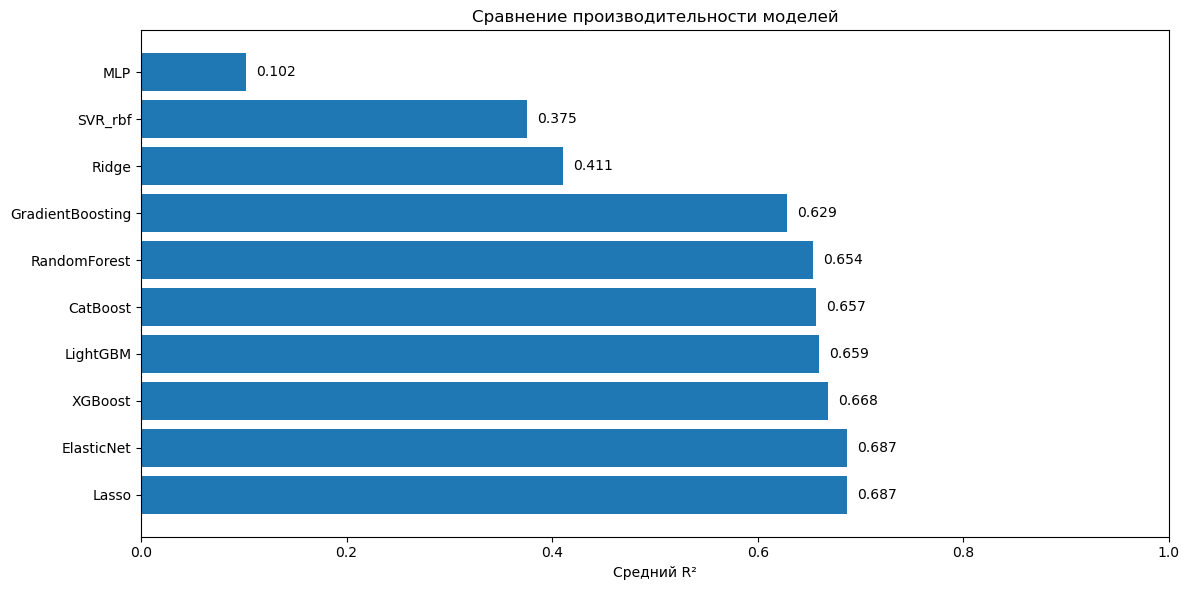


=== ВЗВЕШЕННЫЙ АНСАМБЛЬ ===
Веса моделей (на основе R²):
  RandomForest: 0.118
  GradientBoosting: 0.114
  XGBoost: 0.121
  LightGBM: 0.119
  CatBoost: 0.119
  SVR_rbf: 0.068
  MLP: 0.018
  Ridge: 0.074
  Lasso: 0.124
  ElasticNet: 0.124
Равные веса для всех моделей
Используем топ-3 модели: ['Lasso', 'ElasticNet', 'XGBoost']

=== ОБРАТНОЕ ПРЕОБРАЗОВАНИЕ ===

=== ОЦЕНКА АНСАМБЛЕЙ ===
ОТДЕЛЬНЫЕ МОДЕЛИ:

RandomForest:
  Dry_Clover_g: R²=0.5432, MSE=81.41, MAE=4.75
  Dry_Dead_g: R²=0.3230, MSE=97.92, MAE=6.08
  Dry_Green_g: R²=0.7284, MSE=127.75, MAE=7.24
  Dry_Total_g: R²=0.5432, MSE=265.99, MAE=11.87
  GDM_g: R²=0.6401, MSE=173.08, MAE=9.33

  Средние: R²=0.5556, MSE=149.23, MAE=7.85

GradientBoosting:
  Dry_Clover_g: R²=0.5624, MSE=77.99, MAE=4.62
  Dry_Dead_g: R²=0.2768, MSE=104.60, MAE=6.09
  Dry_Green_g: R²=0.7072, MSE=137.71, MAE=7.21
  Dry_Total_g: R²=0.3825, MSE=359.51, MAE=13.21
  GDM_g: R²=0.6440, MSE=171.20, MAE=9.10

  Средние: R²=0.5146, MSE=170.20, MAE=8.05

XGBoost:
  Dry_

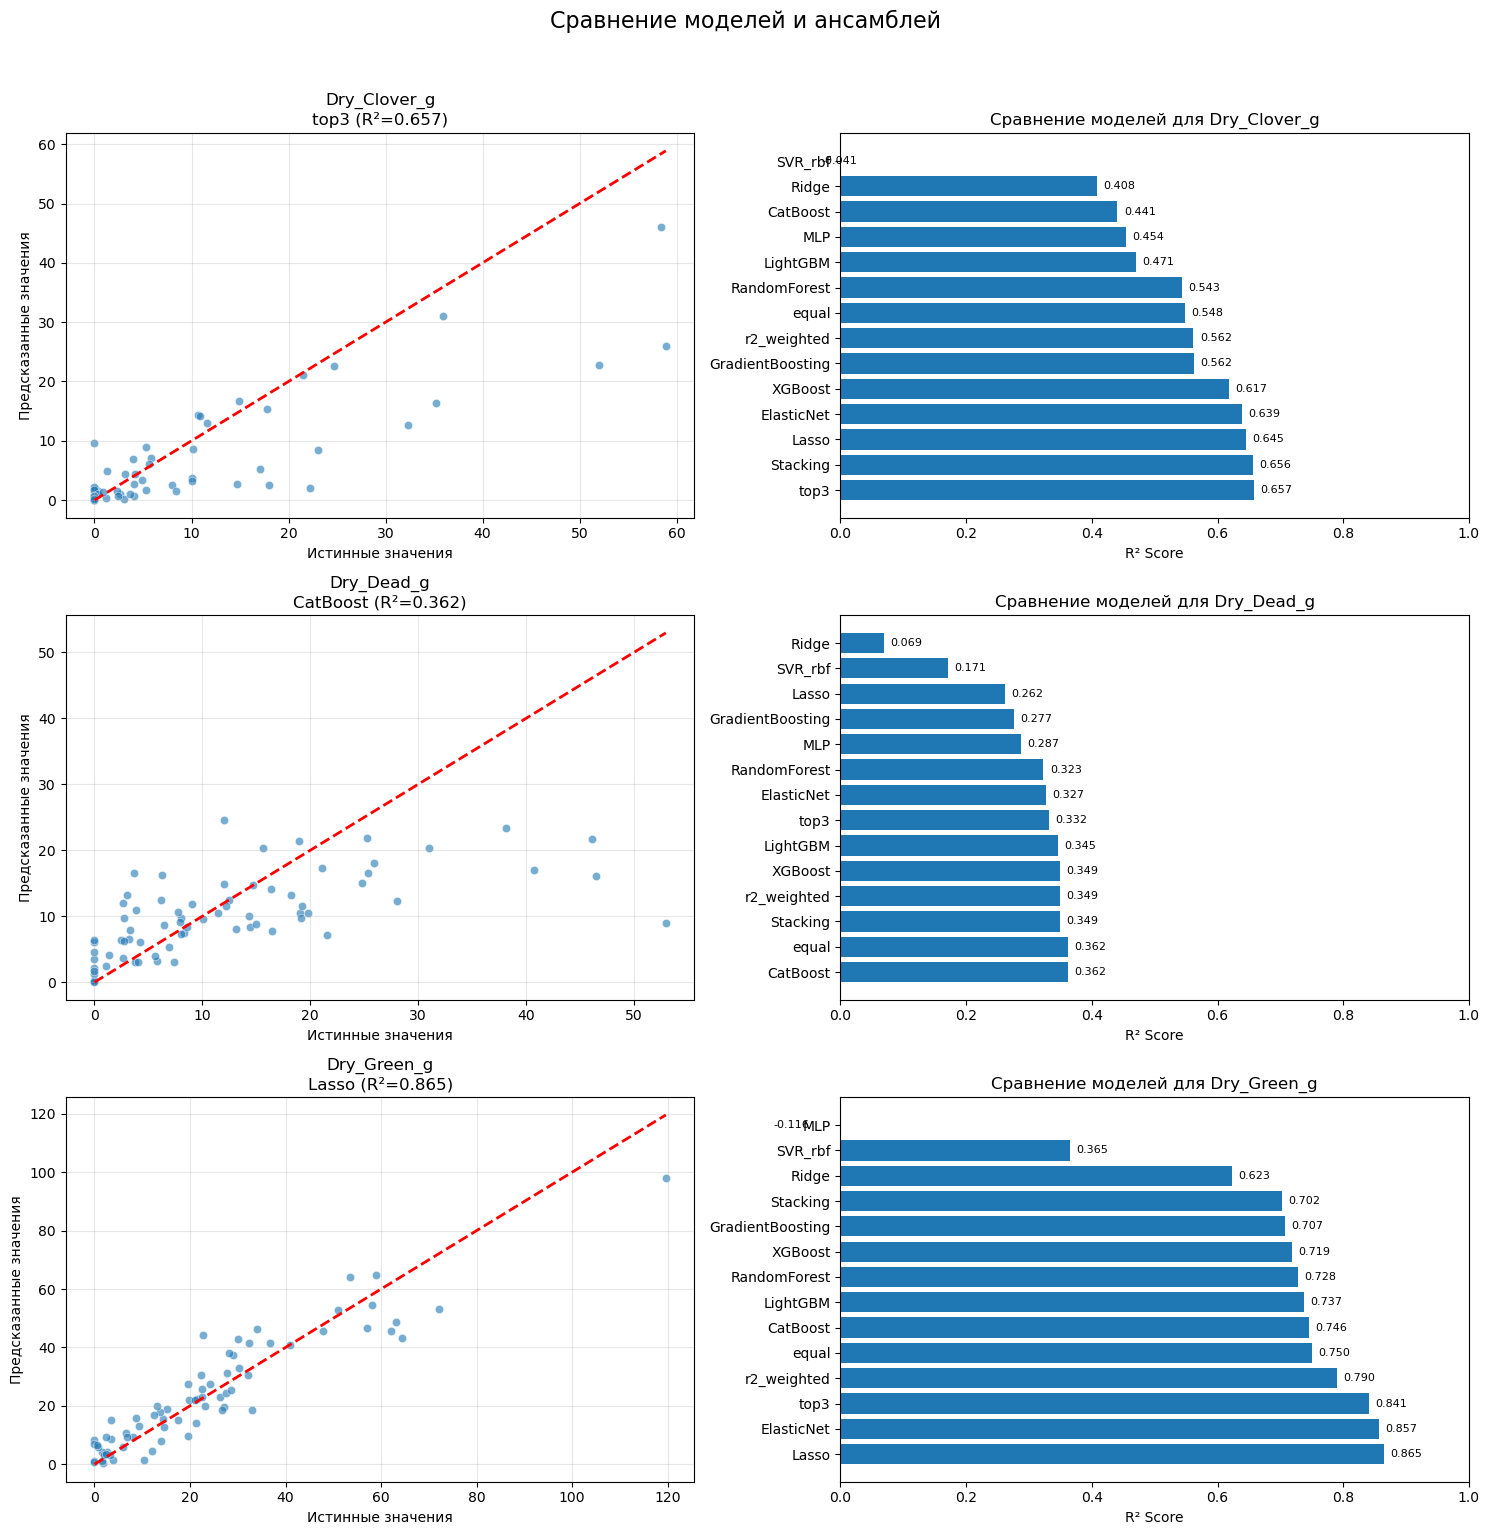


=== ФИНАЛЬНЫЙ ВЫБОР МОДЕЛИ ===

ФИНАЛЬНОЕ СРАВНЕНИЕ:
               Model       Type   Avg_R2
          ElasticNet Individual 0.658649
       Ensemble_top3   Ensemble 0.655715
               Lasso Individual 0.641495
Ensemble_r2_weighted   Ensemble 0.613912
      Ensemble_equal   Ensemble 0.596757
            Stacking   Stacking 0.593145
             XGBoost Individual 0.587586
            CatBoost Individual 0.571392
        RandomForest Individual 0.555572
            LightGBM Individual 0.552968
    GradientBoosting Individual 0.514585
               Ridge Individual 0.414046
             SVR_rbf Individual 0.276180
                 MLP Individual 0.130288

ЛУЧШАЯ МОДЕЛЬ: ElasticNet (R² = 0.6586)

=== СОХРАНЕНИЕ МОДЕЛЕЙ ===
Сохранены предсказания модели ElasticNet
Сохранен ансамбль top3
Сохранены предсказания модели Lasso

Все модели и предобработчики сохранены!

=== ФУНКЦИЯ ДЛЯ ПРЕДСКАЗАНИЙ ===

Пример использования:
new_data = ...  # Новые данные в том же формате
predictions = pr

In [391]:
warnings.filterwarnings('ignore')

# 1. ПРЕОБРАЗОВАНИЕ ТАРГЕТОВ
print("=== ПРЕОБРАЗОВАНИЕ ТАРГЕТОВ ===")

def transform_targets(y, transformation='log', target_names=None):
    """Преобразование таргетов для нормализации распределения"""
    y_transformed = y.copy()
    
    if transformation == 'log':
        print("Применяем логарифмическое преобразование: log1p")
        # Проверяем, что все значения >= 0 для log1p
        min_val = y.min()
        if min_val < 0:
            # Сдвигаем, чтобы все значения были положительными
            shift = abs(min_val) + 1
            y_transformed = np.log1p(y + shift)
            print(f"  Добавлен сдвиг {shift} для отрицательных значений")
        else:
            y_transformed = np.log1p(y)
    
    elif transformation == 'sqrt':
        print("Применяем преобразование квадратным корнем")
        # Для отрицательных значений
        min_val = y.min()
        if min_val < 0:
            shift = abs(min_val)
             #y_transformed = np.sqrt(y + shift)
            y_transformed = (y + shift)^3
            print(f"  Добавлен сдвиг {shift}")
        else:
            y_transformed = np.sqrt(y)
    
    elif transformation == 'boxcox':
        print("Применяем преобразование Бокса-Кокса")
        from scipy import stats
        # Box-Cox требует положительных значений
        min_val = y.min()
        if min_val <= 0:
            shift = abs(min_val) + 1
            y_shifted = y + shift
        else:
            y_shifted = y
        
        y_transformed = np.zeros_like(y)
        for i in range(y.shape[1]):
            y_transformed[:, i], _ = stats.boxcox(y_shifted[:, i])
    
    elif transformation == 'standard':
        print("Применяем стандартизацию (z-score)")
        scaler_y = StandardScaler()
        y_transformed = scaler_y.fit_transform(y)
    
    elif transformation == 'robust':
        print("Применяем RobustScaler")
        from sklearn.preprocessing import RobustScaler
        scaler_y = RobustScaler()
        y_transformed = scaler_y.fit_transform(y)
    
    else:
        print("Без преобразования")
    
    # Анализ преобразования
    if target_names is not None:
        print("\nСтатистики до и после преобразования:")
        for i, name in enumerate(target_names[:3]):  # Покажем первые 3 таргета
            print(f"\n{name}:")
            print(f"  До: mean={y[:, i].mean():.2f}, std={y[:, i].std():.2f}, "
                  f"min={y[:, i].min():.2f}, max={y[:, i].max():.2f}")
            print(f"  После: mean={y_transformed[:, i].mean():.2f}, std={y_transformed[:, i].std():.2f}, "
                  f"min={y_transformed[:, i].min():.2f}, max={y_transformed[:, i].max():.2f}")
    
    return y_transformed

# Выбираем преобразование (попробуйте разные)
transformation = 'sqrt'  # или 'robust', 'log', 'standard', 'boxcox'
y_transformed = transform_targets(y, transformation, target_names)

# 2. РАЗДЕЛЕНИЕ НА TRAIN/TEST С ПРЕОБРАЗОВАННЫМИ ТАРГЕТАМИ
print("\n=== РАЗДЕЛЕНИЕ ДАННЫХ ===")

X_train, X_test, y_train_transformed, y_test_transformed = train_test_split(
    X, y_transformed, test_size=0.2, random_state=42, shuffle=True
)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train (transformed): {y_train_transformed.shape}")
print(f"y_test (transformed): {y_test_transformed.shape}")

# 3. МАСШТАБИРОВАНИЕ ПРИЗНАКОВ
print("\n=== МАСШТАБИРОВАНИЕ ПРИЗНАКОВ ===")

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print("Масштабирование признаков завершено")

# 4. СОЗДАНИЕ И ОБУЧЕНИЕ АНСАМБЛЯ МОДЕЛЕЙ
print("\n=== СОЗДАНИЕ АНСАМБЛЯ МОДЕЛЕЙ ===")

def create_ensemble_predictions(X_train, y_train, X_test, target_names):
    """
    Создает ансамбль из разных моделей для каждого таргета
    """
    models = {
        'RandomForest': RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ),
        'GradientBoosting': GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            min_samples_split=10,
            random_state=42
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        ),
        'LightGBM': lgb.LGBMRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            num_leaves=31,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        'CatBoost': CatBoostRegressor(
            iterations=200,
            learning_rate=0.05,
            depth=6,
            verbose=False,
            random_state=42
        ),
        'SVR_rbf': SVR(
            kernel='rbf',
            C=1.0,
            epsilon=0.1
        ),
        'MLP': MLPRegressor(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            max_iter=500,
            random_state=42,
            early_stopping=True
        ),
        'Ridge': Ridge(alpha=1.0, random_state=42),
        'Lasso': Lasso(alpha=0.1, random_state=42, max_iter=10000),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
    }
    
    predictions = {}
    model_performances = {}
    
    for name, model in models.items():
        print(f"\nОбучение {name}...")
        
        try:
            # Для каждого таргета обучаем отдельную модель
            preds_per_target = []
            r2_scores = []
            
            for i in range(y_train.shape[1]):
                # Обучаем модель
                model.fit(X_train, y_train[:, i])
                
                # Предсказываем
                pred = model.predict(X_test)
                preds_per_target.append(pred)
                
                # Оценка на тестовой выборке (в преобразованном пространстве)
                r2 = r2_score(y_test_transformed[:, i], pred)
                r2_scores.append(r2)
            
            # Сохраняем предсказания
            predictions[name] = np.column_stack(preds_per_target)
            model_performances[name] = {
                'avg_r2': np.mean(r2_scores),
                'r2_scores': r2_scores
            }
            
            print(f"  Средний R²: {np.mean(r2_scores):.4f}")
            print(f"  R² по таргетам: {[f'{s:.3f}' for s in r2_scores]}")
            
        except Exception as e:
            print(f"  Ошибка при обучении {name}: {str(e)}")
            continue
    
    return predictions, model_performances

# Обучаем ансамбль
predictions, model_performances = create_ensemble_predictions(
    X_train_scaled, y_train_transformed, X_test_scaled, target_names
)

# 5. АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ МОДЕЛЕЙ
print("\n=== СРАВНЕНИЕ МОДЕЛЕЙ ===")

# Создаем DataFrame с результатами
performance_df = pd.DataFrame({
    'Model': list(model_performances.keys()),
    'Avg_R2': [model_performances[m]['avg_r2'] for m in model_performances.keys()]
}).sort_values('Avg_R2', ascending=False)

print("\nРейтинг моделей (по среднему R²):")
print(performance_df.to_string(index=False))

# Визуализация сравнения моделей
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
bars = plt.barh(performance_df['Model'], performance_df['Avg_R2'])
plt.xlabel('Средний R²')
plt.title('Сравнение производительности моделей')
plt.xlim([0, 1])

# Добавляем значения на столбцы
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

# 6. ВЗВЕШЕННЫЙ АНСАМБЛЬ (WEIGHTED ENSEMBLE)
print("\n=== ВЗВЕШЕННЫЙ АНСАМБЛЬ ===")

def create_weighted_ensemble(predictions, model_performances, method='r2_weighted'):
    """
    Создает взвешенный ансамбль предсказаний
    """
    if method == 'r2_weighted':
        # Веса пропорциональны R² каждой модели
        weights = {}
        total_r2 = sum(model_performances[m]['avg_r2'] for m in predictions.keys())
        
        for model_name in predictions.keys():
            weight = model_performances[model_name]['avg_r2'] / total_r2
            weights[model_name] = weight
        
        print("Веса моделей (на основе R²):")
        for model_name, weight in weights.items():
            print(f"  {model_name}: {weight:.3f}")
    
    elif method == 'equal':
        # Равные веса
        n_models = len(predictions)
        weights = {model_name: 1/n_models for model_name in predictions.keys()}
        print("Равные веса для всех моделей")
    
    elif method == 'top3':
        # Используем только 3 лучшие модели
        top_models = performance_df.head(3)['Model'].tolist()
        weights = {}
        for model_name in predictions.keys():
            if model_name in top_models:
                weights[model_name] = 1/len(top_models)
            else:
                weights[model_name] = 0
        
        print(f"Используем топ-3 модели: {top_models}")
    
    # Взвешенное усреднение
    ensemble_pred = np.zeros_like(list(predictions.values())[0])
    
    for model_name, pred in predictions.items():
        if model_name in weights and weights[model_name] > 0:
            ensemble_pred += weights[model_name] * pred
    
    return ensemble_pred, weights

# Создаем несколько ансамблей
ensemble_methods = ['r2_weighted', 'equal', 'top3']
ensemble_results = {}

for method in ensemble_methods:
    ensemble_pred, weights = create_weighted_ensemble(predictions, model_performances, method)
    ensemble_results[method] = ensemble_pred

# 7. ОБРАТНОЕ ПРЕОБРАЗОВАНИЕ ПРЕДСКАЗАНИЙ
print("\n=== ОБРАТНОЕ ПРЕОБРАЗОВАНИЕ ===")

def inverse_transform_targets(y_transformed, y_original, transformation='log'):
    """Обратное преобразование предсказаний"""
    y_inverse = y_transformed.copy()
    
    if transformation == 'log':
        # Обратное от log1p
        y_inverse = np.expm1(y_transformed)
    
    elif transformation == 'sqrt':
        # Обратное от sqrt
        y_inverse = y_transformed ** 2
    
    elif transformation == 'boxcox':
        # Обратное преобразование Бокса-Кокса
        from scipy import stats
        y_inverse = np.zeros_like(y_transformed)
        for i in range(y_transformed.shape[1]):
            # Нам нужны оригинальные параметры преобразования
            # Упрощенный вариант: используем среднее и std оригинальных данных
            mean_original = np.mean(y_original[:, i])
            std_original = np.std(y_original[:, i])
            mean_transformed = np.mean(y_transformed[:, i])
            std_transformed = np.std(y_transformed[:, i])
            
            # Масштабируем обратно
            y_inverse[:, i] = (y_transformed[:, i] - mean_transformed) / std_transformed * std_original + mean_original
    
    elif transformation in ['standard', 'robust']:
        # Для стандартизации нужно использовать сохраненный scaler
        # Здесь упрощенный вариант
        y_inverse = np.zeros_like(y_transformed)
        for i in range(y_transformed.shape[1]):
            mean_original = np.mean(y_original[:, i])
            std_original = np.std(y_original[:, i])
            mean_transformed = np.mean(y_transformed[:, i])
            std_transformed = np.std(y_transformed[:, i])
            
            y_inverse[:, i] = (y_transformed[:, i] - mean_transformed) / std_transformed * std_original + mean_original
    
    else:
        # Без преобразования
        y_inverse = y_transformed
    
    return y_inverse

# Получаем оригинальные y_test (без преобразования)
# Нам нужно знать, какие индексы попали в тестовую выборку
indices = np.arange(len(y))
_, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
y_test_original = y[test_indices]

# Обратное преобразование для каждого ансамбля
ensemble_final = {}
for method, ensemble_pred in ensemble_results.items():
    # Обратное преобразование
    ensemble_inverse = inverse_transform_targets(ensemble_pred, y_test_original, transformation)
    ensemble_final[method] = ensemble_inverse

# Также обратное преобразование для отдельных моделей (для сравнения)
model_predictions_final = {}
for model_name, pred in predictions.items():
    model_predictions_final[model_name] = inverse_transform_targets(pred, y_test_original, transformation)

# 8. ОЦЕНКА АНСАМБЛЕЙ
print("\n=== ОЦЕНКА АНСАМБЛЕЙ ===")

def evaluate_predictions(y_true, y_pred, target_names, model_name="Model"):
    """Оценка предсказаний"""
    print(f"\n{model_name}:")
    
    r2_scores = []
    mse_scores = []
    mae_scores = []
    
    for i in range(y_true.shape[1]):
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        
        r2_scores.append(r2)
        mse_scores.append(mse)
        mae_scores.append(mae)
        
        if i < len(target_names):
            print(f"  {target_names[i]}: R²={r2:.4f}, MSE={mse:.2f}, MAE={mae:.2f}")
        else:
            print(f"  Таргет {i+1}: R²={r2:.4f}, MSE={mse:.2f}, MAE={mae:.2f}")
    
    avg_r2 = np.mean(r2_scores)
    avg_mse = np.mean(mse_scores)
    avg_mae = np.mean(mae_scores)
    
    print(f"\n  Средние: R²={avg_r2:.4f}, MSE={avg_mse:.2f}, MAE={avg_mae:.2f}")
    
    return {
        'avg_r2': avg_r2,
        'avg_mse': avg_mse,
        'avg_mae': avg_mae,
        'r2_scores': r2_scores
    }

# Оцениваем отдельные модели
print("ОТДЕЛЬНЫЕ МОДЕЛИ:")
for model_name, pred in model_predictions_final.items():
    evaluate_predictions(y_test_original, pred, target_names, model_name)

# Оцениваем ансамбли
print("\nАНСАМБЛИ:")
ensemble_evaluations = {}
for method, pred in ensemble_final.items():
    eval_results = evaluate_predictions(y_test_original, pred, target_names, f"Ансамбль ({method})")
    ensemble_evaluations[method] = eval_results

# 9. СТЕКИНГ (STACKING) - ПРОДВИНУТЫЙ АНСАМБЛЬ
print("\n=== СТЕКИНГ АНСАМБЛЬ ===")

def create_stacking_ensemble(X_train, y_train, X_test, target_names):
    """
    Создает stacking ансамбль для каждого таргета
    """
    # Базовые модели
    base_models = [
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
        ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1)),
        ('lgbm', lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1, n_jobs=-1)),
        ('mlp', MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500, random_state=42)),
    ]
    
    # Мета-модель
    meta_model = Ridge(alpha=1.0, random_state=42)
    
    stacking_predictions = []
    
    for i in range(y_train.shape[1]):
        print(f"  Обучение stacking для таргета {i+1} ({target_names[i] if i < len(target_names) else ''})")
        
        # Создаем stacking регрессор
        stacking_reg = StackingRegressor(
            estimators=base_models,
            final_estimator=meta_model,
            cv=5,
            n_jobs=-1,
            passthrough=False  # Не добавлять исходные признаки
        )
        
        # Обучаем
        stacking_reg.fit(X_train, y_train[:, i])
        
        # Предсказываем
        pred = stacking_reg.predict(X_test)
        stacking_predictions.append(pred)
    
    return np.column_stack(stacking_predictions)

# Создаем stacking ансамбль
stacking_pred_transformed = create_stacking_ensemble(
    X_train_scaled, y_train_transformed, X_test_scaled, target_names
)

# Обратное преобразование
stacking_pred = inverse_transform_targets(stacking_pred_transformed, y_test_original, transformation)

# Оцениваем stacking
print("\nSTACKING АНСАМБЛЬ:")
stacking_eval = evaluate_predictions(y_test_original, stacking_pred, target_names, "Stacking Ensemble")

# 10. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
print("\n=== ВИЗУАЛИЗАЦИЯ ===")

def visualize_comparison(y_true, predictions_dict, target_names):
    """Визуализация сравнения моделей"""
    n_targets = min(3, len(target_names))  # Покажем первые 3 таргета
    fig, axes = plt.subplots(n_targets, 2, figsize=(15, 5*n_targets))
    
    if n_targets == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_targets):
        # График 1: Предсказания vs Истинные значения (лучший ансамбль)
        ax1 = axes[i, 0]
        
        # Находим лучшую модель по R² для этого таргета
        best_model = None
        best_r2 = -np.inf
        
        for model_name, pred in predictions_dict.items():
            r2 = r2_score(y_true[:, i], pred[:, i])
            if r2 > best_r2:
                best_r2 = r2
                best_model = model_name
        
        best_pred = predictions_dict[best_model][:, i]
        
        ax1.scatter(y_true[:, i], best_pred, alpha=0.6, edgecolors='w', linewidth=0.5)
        min_val = min(y_true[:, i].min(), best_pred.min())
        max_val = max(y_true[:, i].max(), best_pred.max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        ax1.set_xlabel('Истинные значения')
        ax1.set_ylabel('Предсказанные значения')
        ax1.set_title(f'{target_names[i]}\n{best_model} (R²={best_r2:.3f})')
        ax1.grid(True, alpha=0.3)
        
        # График 2: Сравнение R² для всех моделей
        ax2 = axes[i, 1]
        
        model_names = []
        r2_values = []
        
        for model_name, pred in predictions_dict.items():
            r2 = r2_score(y_true[:, i], pred[:, i])
            model_names.append(model_name)
            r2_values.append(r2)
        
        # Сортируем по R²
        sorted_idx = np.argsort(r2_values)[::-1]
        model_names_sorted = [model_names[idx] for idx in sorted_idx]
        r2_sorted = [r2_values[idx] for idx in sorted_idx]
        
        bars = ax2.barh(range(len(model_names_sorted)), r2_sorted)
        ax2.set_yticks(range(len(model_names_sorted)))
        ax2.set_yticklabels(model_names_sorted)
        ax2.set_xlabel('R² Score')
        ax2.set_title(f'Сравнение моделей для {target_names[i]}')
        ax2.set_xlim([0, 1])
        
        # Добавляем значения на столбцы
        for j, bar in enumerate(bars):
            width = bar.get_width()
            ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{width:.3f}', ha='left', va='center', fontsize=8)
    
    plt.suptitle('Сравнение моделей и ансамблей', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Объединяем все предсказания для визуализации
all_predictions = {**model_predictions_final, **ensemble_final, 'Stacking': stacking_pred}

# Визуализируем
visualize_comparison(y_test_original, all_predictions, target_names)

# 11. ФИНАЛЬНЫЙ ВЫБОР И СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ
print("\n=== ФИНАЛЬНЫЙ ВЫБОР МОДЕЛИ ===")

# Сравниваем все подходы
final_comparison = []

# Добавляем отдельные модели
for model_name, pred in model_predictions_final.items():
    avg_r2 = np.mean([r2_score(y_test_original[:, i], pred[:, i]) for i in range(y_test_original.shape[1])])
    final_comparison.append({
        'Model': model_name,
        'Type': 'Individual',
        'Avg_R2': avg_r2
    })

# Добавляем ансамбли
for method, pred in ensemble_final.items():
    avg_r2 = np.mean([r2_score(y_test_original[:, i], pred[:, i]) for i in range(y_test_original.shape[1])])
    final_comparison.append({
        'Model': f'Ensemble_{method}',
        'Type': 'Ensemble',
        'Avg_R2': avg_r2
    })

# Добавляем stacking
avg_r2_stacking = np.mean([r2_score(y_test_original[:, i], stacking_pred[:, i]) for i in range(y_test_original.shape[1])])
final_comparison.append({
    'Model': 'Stacking',
    'Type': 'Stacking',
    'Avg_R2': avg_r2_stacking
})

# Создаем DataFrame и сортируем
final_df = pd.DataFrame(final_comparison).sort_values('Avg_R2', ascending=False)

print("\nФИНАЛЬНОЕ СРАВНЕНИЕ:")
print(final_df.to_string(index=False))

# Выбираем лучшую модель
best_model_info = final_df.iloc[0]
print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_info['Model']} (R² = {best_model_info['Avg_R2']:.4f})")

# 12. СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ
print("\n=== СОХРАНЕНИЕ МОДЕЛЕЙ ===")

import joblib
import pickle

# Сохраняем лучшие модели (топ-3)
top_models = final_df.head(3)['Model'].tolist()

for model_name in top_models:
    if model_name.startswith('Ensemble_'):
        # Для ансамблей сохраняем веса и предсказания
        method = model_name.replace('Ensemble_', '')
        if method in ensemble_final:
            joblib.dump(ensemble_final[method], f'ensemble_{method}_predictions.pkl')
            print(f"Сохранен ансамбль {method}")
    
    elif model_name in model_predictions_final:
        # Для отдельных моделей
        joblib.dump(model_predictions_final[model_name], f'{model_name}_predictions.pkl')
        print(f"Сохранены предсказания модели {model_name}")
    
    elif model_name == 'Stacking':
        joblib.dump(stacking_pred, 'stacking_predictions.pkl')
        print("Сохранены предсказания Stacking ансамбля")

# Сохраняем скалеры и информацию о преобразовании
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump({'transformation': transformation, 'target_names': target_names}, 'transformation_info.pkl')

print("\nВсе модели и предобработчики сохранены!")

# 13. ФУНКЦИЯ ДЛЯ ПРЕДСКАЗАНИЙ НА НОВЫХ ДАННЫХ
print("\n=== ФУНКЦИЯ ДЛЯ ПРЕДСКАЗАНИЙ ===")

def predict_with_ensemble(new_data, ensemble_type='stacking'):
    """
    Функция для предсказаний на новых данных
    """
    # Масштабирование признаков
    new_data_scaled = scaler_X.transform(new_data)
    
    if ensemble_type == 'stacking':
        # Используем stacking
        predictions_transformed = []
        
        # Нужно переобучить или загрузить сохраненные модели
        # Здесь упрощенный вариант
        for i in range(len(target_names)):
            # В реальности нужно загрузить сохраненные модели
            # Для примера используем простую модель
            model = xgb.XGBRegressor()
            # Здесь должен быть код загрузки обученной модели
            predictions_transformed.append(np.zeros(len(new_data)))  # Заглушка
        
        predictions_transformed = np.column_stack(predictions_transformed)
    
    else:
        # Используем взвешенный ансамбль
        # Нужно загрузить все сохраненные модели
        # Здесь упрощенный вариант
        predictions_transformed = np.zeros((len(new_data), len(target_names)))
    
    # Обратное преобразование
    predictions = inverse_transform_targets(predictions_transformed, 
                                           np.zeros((1, len(target_names))),  # Заглушка
                                           transformation)
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(predictions, columns=target_names)
    
    return results_df

print("""
Пример использования:
new_data = ...  # Новые данные в том же формате
predictions = predict_with_ensemble(new_data, ensemble_type='stacking')
print(predictions)
""")

In [435]:
warnings.filterwarnings('ignore')

print("=== ДЕТАЛЬНЫЙ АНАЛИЗ LASSO МОДЕЛИ ===")

# Обучаем Lasso с лучшими параметрами для каждого таргета
lasso_predictions_transformed = []
lasso_models = []
lasso_coefs = []

# Параметры Lasso (подбираем для каждого таргета)
lasso_params = {
    'Dry_Clover_g': {'alpha': 0.01, 'max_iter': 10000},
    'Dry_Dead_g': {'alpha': 0.05, 'max_iter': 10000},
    'Dry_Green_g': {'alpha': 0.001, 'max_iter': 10000},
    'Dry_Total_g': {'alpha': 0.005, 'max_iter': 10000},
    'GDM_g': {'alpha': 0.001, 'max_iter': 10000}
}

for i, target_name in enumerate(target_names):
    print(f"\nАнализ Lasso для {target_name}:")
    
    # Используем параметры или подбираем
    if target_name in lasso_params:
        params = lasso_params[target_name]
    else:
        params = {'alpha': 0.1, 'max_iter': 10000}
    
    # Обучаем модель
    model = Lasso(**params, random_state=42, tol=1e-4)
    model.fit(X_train_scaled, y_train_transformed[:, i])
    
    # Предсказываем
    pred = model.predict(X_test_scaled)
    lasso_predictions_transformed.append(pred)
    lasso_models.append(model)
    
    # Сохраняем коэффициенты
    coef = model.coef_
    lasso_coefs.append(coef)
    
    # Анализ коэффициентов
    n_nonzero = np.sum(np.abs(coef) > 1e-5)
    print(f"  Ненулевых коэффициентов: {n_nonzero} из {len(coef)}")
    print(f"  Наибольшие коэффициенты:")
    
    # Топ-10 по абсолютному значению
    abs_coef = np.abs(coef)
    top_indices = np.argsort(abs_coef)[-10:][::-1]
    
    for idx in top_indices[:5]:
        if abs_coef[idx] > 0:
            if hasattr(feature_names, '__len__') and idx < len(feature_names):
                feat_name = feature_names[idx]
            else:
                feat_name = f'feature_{idx}'
            print(f"    {feat_name}: {coef[idx]:.4f}")

# Объединяем предсказания
y_pred_lasso_transformed = np.column_stack(lasso_predictions_transformed)

# Обратное преобразование
y_pred_lasso_original = inverse_transform_targets(y_pred_lasso_transformed, y_test_original, transformation)

# Оценка
lasso_r2 = r2_score(y_test_original, y_pred_lasso_original)
print(f"\nОбщий R² Lasso: {lasso_r2:.4f}")

# По таргетам
print("\nR² по таргетам:")
for i, target_name in enumerate(target_names):
    r2 = r2_score(y_test_original[:, i], y_pred_lasso_original[:, i])
    print(f"  {target_name}: {r2:.4f}")

=== ДЕТАЛЬНЫЙ АНАЛИЗ LASSO МОДЕЛИ ===

Анализ Lasso для Dry_Clover_g:
  Ненулевых коэффициентов: 241 из 2076
  Наибольшие коэффициенты:
    Species_Clover: 0.6807
    State_NSW: -0.2617
    img_feat_296: 0.2395
    img_feat_1867: 0.2346
    day_cos: 0.2289

Анализ Lasso для Dry_Dead_g:
  Ненулевых коэффициентов: 118 из 2076
  Наибольшие коэффициенты:
    State_WA: -0.4702
    season: 0.2626
    img_feat_1489: -0.2208
    img_feat_688: 0.1983
    State_Tas: 0.1943

Анализ Lasso для Dry_Green_g:
  Ненулевых коэффициентов: 292 из 2076
  Наибольшие коэффициенты:
    Height_Ave_cm: 0.8839
    Species_Clover: -0.5329
    Species_Phalaris: 0.3687
    State_NSW: 0.3586
    Species_Ryegrass: -0.2559

Анализ Lasso для Dry_Total_g:
  Ненулевых коэффициентов: 258 из 2076
  Наибольшие коэффициенты:
    Height_Ave_cm: 0.6391
    img_feat_1734: -0.3108
    Species_Ryegrass: -0.2712
    img_feat_1539: 0.2652
    img_feat_1697: -0.2623

Анализ Lasso для GDM_g:
  Ненулевых коэффициентов: 295 из 2076
  Н

In [443]:
def analyze_data_characteristics(df, X, y, target_names):
    """Анализ характеристик данных для улучшения модели"""
    
    print("=== АНАЛИЗ ХАРАКТЕРИСТИК ДАННЫХ ===")
    
    # 1. Проверяем распределение таргетов
    print("\n1. Распределение таргетов:")
    for i, name in enumerate(target_names):
        print(f"\n{name}:")
        print(f"  Min: {y[:, i].min():.2f}")
        print(f"  Max: {y[:, i].max():.2f}")
        print(f"  Mean: {y[:, i].mean():.2f}")
        print(f"  Std: {y[:, i].std():.2f}")
        print(f"  Skewness: {pd.Series(y[:, i]).skew():.2f}")
        print(f"  Kurtosis: {pd.Series(y[:, i]).kurtosis():.2f}")
        
        # Процент нулевых значений
        zero_percent = np.sum(y[:, i] == 0) / len(y) * 100
        print(f"  Нулевых значений: {zero_percent:.1f}%")
    
    # 2. Корреляции между признаками и таргетами
    print("\n2. Корреляции с таргетами (топ-10 для каждого):")
    
    # Создаем DataFrame для корреляций
    if hasattr(feature_names, '__len__'):
        # Если у нас есть имена признаков
        X_df = pd.DataFrame(X, columns=feature_names[:X.shape[1]])
    else:
        X_df = pd.DataFrame(X)
    
    y_df = pd.DataFrame(y, columns=target_names)
    
    # Объединяем для корреляций
    data_corr = pd.concat([X_df, y_df], axis=1)
    
    for target in target_names:
        # Находим корреляции с этим таргетом
        corrs = data_corr.corr()[target].abs().sort_values(ascending=False)
        
        # Исключаем сам таргет и другие таргеты
        top_features = []
        for feat, corr in corrs.items():
            if feat not in target_names:
                top_features.append((feat, corr))
            if len(top_features) >= 10:
                break
        
        print(f"\n{target}:")
        for feat, corr in top_features:
            print(f"  {feat}: {corr:.3f}")
    
    # 3. Анализ выбросов
    print("\n3. Анализ выбросов (правило 3σ):")
    for i, name in enumerate(target_names):
        mean_val = np.mean(y[:, i])
        std_val = np.std(y[:, i])
        outliers = np.sum(np.abs(y[:, i] - mean_val) > 3 * std_val)
        print(f"  {name}: {outliers} выбросов ({outliers/len(y)*100:.1f}%)")
    
    # 4. Анализ мультиколлинеарности признаков
    print("\n4. Анализ мультиколлинеарности:")
    
    # Вычисляем корреляции между признаками
    if X.shape[1] < 100:  # Если не слишком много признаков
        corr_matrix = np.corrcoef(X.T)
        
        # Находим высокие корреляции
        high_corr_pairs = []
        for i in range(corr_matrix.shape[0]):
            for j in range(i+1, corr_matrix.shape[1]):
                if abs(corr_matrix[i, j]) > 0.8:  # Порог для сильной корреляции
                    high_corr_pairs.append((i, j, corr_matrix[i, j]))
        
        print(f"  Пар признаков с корреляцией > 0.8: {len(high_corr_pairs)}")
        if len(high_corr_pairs) > 0:
            print("  Примеры:")
            for i, j, corr in high_corr_pairs[:5]:
                if hasattr(feature_names, '__len__'):
                    feat1 = feature_names[i] if i < len(feature_names) else f'feature_{i}'
                    feat2 = feature_names[j] if j < len(feature_names) else f'feature_{j}'
                else:
                    feat1 = f'feature_{i}'
                    feat2 = f'feature_{j}'
                print(f"    {feat1} - {feat2}: {corr:.3f}")
    
    return data_corr

# Запускаем анализ
data_corr = analyze_data_characteristics(df, X, y, target_names)

=== АНАЛИЗ ХАРАКТЕРИСТИК ДАННЫХ ===

1. Распределение таргетов:

Dry_Clover_g:
  Min: 0.00
  Max: 71.79
  Mean: 6.65
  Std: 12.10
  Skewness: 2.84
  Kurtosis: 9.07
  Нулевых значений: 37.8%

Dry_Dead_g:
  Min: 0.00
  Max: 83.84
  Mean: 12.04
  Std: 12.38
  Skewness: 1.76
  Kurtosis: 4.20
  Нулевых значений: 11.2%

Dry_Green_g:
  Min: 0.00
  Max: 157.98
  Mean: 26.62
  Std: 25.37
  Skewness: 1.75
  Kurtosis: 3.91
  Нулевых значений: 5.0%

Dry_Total_g:
  Min: 1.04
  Max: 185.70
  Mean: 45.32
  Std: 27.94
  Skewness: 1.43
  Kurtosis: 3.08
  Нулевых значений: 0.0%

GDM_g:
  Min: 1.04
  Max: 157.98
  Mean: 33.27
  Std: 24.90
  Skewness: 1.56
  Kurtosis: 3.05
  Нулевых значений: 0.0%

2. Корреляции с таргетами (топ-10 для каждого):

Dry_Clover_g:
  Species_Clover: 0.553
  img_feat_309: 0.513
  img_feat_435: 0.465
  img_feat_1268: 0.460
  img_feat_1835: 0.445
  img_feat_1670: 0.437
  img_feat_96: 0.437
  img_feat_840: 0.432
  img_feat_1458: 0.413
  img_feat_181: 0.402

Dry_Dead_g:
  img_feat_